In [1]:
!nvidia-smi

Wed Apr  3 11:53:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150           On  | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8              N/A / ERR! |      4MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
import torch

torch.cuda.get_device_name(0)

'NVIDIA GeForce MX150'

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.get_num_threads()

4

In [4]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as data

Poniżej są zdefiniowane konfigurowalne modele: LSTM, GRU oraz RNN

In [102]:
# LSTM

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0, bidirectional=False):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        D = 2 if bidirectional else 1

        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.linear = nn.Linear(D * self.hidden_size, self.output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [103]:
# GRU

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0, bidirectional=False):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        D = 2 if bidirectional else 1

        self.gru = nn.GRU(self.input_size, self.hidden_size, self.num_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.linear = nn.Linear(D * self.hidden_size, self.output_size)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.linear(x)
        return x

In [104]:
# RNN

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0, bidirectional=False):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        D = 2 if bidirectional else 1

        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.fc = nn.Linear(D * self.hidden_size, self.output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

In [105]:
from torch.utils.data import Dataset

class FunctionDataset:
    class SequenceDs(Dataset):
        def __init__(self, X, y) -> None:
            super().__init__()
            self.X = X
            self.y = y

        def __len__(self):
            return len(self.y)

        def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
            return torch.tensor(self.X[index]).float(), torch.tensor(self.y[index]).float()

    def __init__(self, y_f, lookback, split_ratio=0.7):

        self.y_f = y_f
        self.total_samples = len(y_f)
        self.lookback = lookback

        X, y = self.generate_sequence(self.y_f, self.lookback)

        # split into train, validation and test set
        self.X = X[:int((self.total_samples - lookback) * split_ratio)]
        self.X_test = X[int((self.total_samples - lookback) *split_ratio):]

        self.y = y[:int((self.total_samples - lookback) * split_ratio)]
        self.y_test = y[int((self.total_samples - lookback) * split_ratio):]

        print(f'[Dataset]: total samples {self.total_samples}, sequence length {self.lookback}, total sequences {len(X)}, split ratio {split_ratio}, train {len(self.X)}, test {len(self.X_test)}')

    def generate_sequence(self, y, l):
        X_seq = []
        y_seq = []
        for i in range(len(y) - l):
            X_seq.append(y[i:i+l])
            y_seq.append(y[i+1:i+l+1])
        return np.array(X_seq), np.array(y_seq)

    def get_train_ds(self):
        return self.SequenceDs(self.X, self.y)

    def get_test_ds(self):
        return self.SequenceDs(self.X_test, self.y_test)

Dataset do poprzednich laboratoriów, by móc używać DataLoader i mieć możliwość uczyć z batchami.

In [9]:
import time

def train(net, trainloader, testloader, criterion, optimizer, epochs, points_to_print=20):
    learning_start = time.time()

    net.train()

    print_every_n_batches = max(1, round(epochs * len(trainloader) / points_to_print))
    print('Print every %d batches' % print_every_n_batches)

    for epoch in range(epochs):
        # train
        for i, data in enumerate(trainloader, 0):
            net.train()

            X, y = data

            if len(X.shape) == 2:
                X = X.unsqueeze(2)
                y = y.unsqueeze(2)

            X = X.cuda()
            y = y.cuda()

            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(X)
            loss = criterion(outputs, y)
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), 3)
            optimizer.step()


            if (epoch * len(trainloader) + (i + 1)) % print_every_n_batches == print_every_n_batches - 1:

                # validate
                net.eval()

                train_loss = 0.0
                val_loss = 0.0

                with torch.no_grad():
                    for _, data in enumerate(trainloader, 0):
                        X, y = data

                        if len(X.shape) == 2:
                            X = X.unsqueeze(2)
                            y = y.unsqueeze(2)

                        X = X.cuda()
                        y = y.cuda()

                        outputs = net(X)
                        loss = criterion(outputs, y)

                        train_loss += loss.item()

                    for _, data in enumerate(testloader, 0):
                        X, y = data

                        if len(X.shape) == 2:
                            X = X.unsqueeze(2)
                            y = y.unsqueeze(2)

                        X = X.cuda()
                        y = y.cuda()

                        outputs = net(X)
                        loss = criterion(outputs, y)

                        val_loss += loss.item()


                print('[%4d, %4d] train RMSE: %.6g, test RMSE: %.6g' % (epoch + 1, i + 1, np.sqrt(train_loss / len(trainloader)), np.sqrt(val_loss / len(testloader))))


    learning_end = time.time()

    return learning_end - learning_start

By zapobiec ekspodującemu gradientowi (kiedy wartośći gradientu stają się zbyt duże, co pogarsza/uniemożliwia proces uczenia, ze względu na to, że funkcja strat może nie malać albo rosnąć, lub dokladność może fluktuować albo nie rosnąć) można np obcinać zbyt duży gradient. W tym przypadku została użyta funkcja `nn.utils.clip_grad_norm_`. z normą 3: każdy z członów sumy jest podnoszony do trzeciej potęgi oraz liczony jest pierwiastek trzeciego stopnia z sumy. Innym problemem jest "vanishing gradient", kiedy wartości stają się zbyt małe. Zapobiec temu można używając innej funkcji aktywacji, obcinając gradient, normalizując dane wejściowe. Obserwować gradient można np tworząc histogram gradientu.

In [10]:
def predict(net, loader, criterion):
    net.eval()

    preds = []
    loss = 0.0

    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            X, y = data

            if len(X.shape) == 2:
                X = X.unsqueeze(2)
                y = y.unsqueeze(2)

            X = X.cuda()
            y = y.cuda()

            outputs = net(X)
            loss += criterion(outputs, y).item()

            # append joined outpus
            preds = np.concatenate((preds, outputs[:, -1, :].cpu().numpy().flatten()))

    return loss / len(loader), preds

In [11]:
def plot_model_results(title, actual, train_preds, test_preds, lookback = 4):
    train_serie = np.ones_like(actual) * np.nan
    test_serie = np.ones_like(actual) * np.nan

    train_serie[lookback:lookback + len(train_preds)] = train_preds
    test_serie[lookback + len(train_preds):] = test_preds

    plt.plot(actual, label='Actual')
    plt.plot(train_serie, label='Train predicted', color='red')
    plt.plot(test_serie, label='Test predicted', color='green')
    plt.title(title)
    plt.legend()
    plt.show()

In [12]:
def plot_all_results(title, lookback, actual, train_preds_lstm, test_preds_lstm, train_preds_gru, test_preds_gru, train_preds_rnn, test_preds_rnn):
    train_serie_lstm = np.ones_like(actual) * np.nan
    test_serie_lstm = np.ones_like(actual) * np.nan
    train_serie_lstm[lookback:lookback + len(train_preds_lstm)] = train_preds_lstm
    test_serie_lstm[lookback + len(train_preds_lstm):] = test_preds_lstm

    train_serie_gru = np.ones_like(actual) * np.nan
    test_serie_gru = np.ones_like(actual) * np.nan
    train_serie_gru[lookback:lookback + len(train_preds_gru)] = train_preds_gru
    test_serie_gru[lookback + len(train_preds_gru):] = test_preds_gru

    train_serie_rnn = np.ones_like(actual) * np.nan
    test_serie_rnn = np.ones_like(actual) * np.nan
    train_serie_rnn[lookback:lookback + len(train_preds_rnn)] = train_preds_rnn
    test_serie_rnn[lookback + len(train_preds_rnn):] = test_preds_rnn


    plt.figure(figsize=(20, 5))

    plt.subplot(1, 3, 1)
    plt.plot(actual, label='Actual')
    plt.plot(train_serie_lstm, label='Train predicted', color='red')
    plt.plot(test_serie_lstm, label='Test predicted', color='green')
    plt.title('LSTM model')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(actual, label='Actual')
    plt.plot(train_serie_gru, label='Train predicted', color='red')
    plt.plot(test_serie_gru, label='Test predicted', color='green')
    plt.title('GRU model')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(actual, label='Actual')
    plt.plot(train_serie_rnn, label='Train predicted', color='red')
    plt.plot(test_serie_rnn, label='Test predicted', color='green')
    plt.title('RNN model')
    plt.legend()

    plt.suptitle(title, fontsize=16, y=1.01)

    plt.show()

In [13]:
batch_size = 8
epochs = 2000

### Zad 1

In [15]:
# read data from ariline-passangers.csv. 
df = pd.read_csv('airline-passengers.csv')
df["Passengers"] = df["Passengers"].apply(lambda x: float(x))

df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [16]:
# print df data types
df.dtypes

Month          object
Passengers    float64
dtype: object

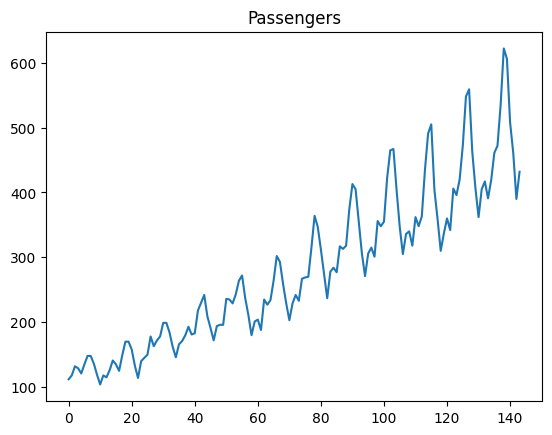

In [17]:
plt.plot(df['Passengers'])
plt.title('Passengers')
plt.show()

Dane wejściowe

In [18]:
ds = FunctionDataset(df['Passengers'], lookback=4, split_ratio=0.8)

train_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=True, batch_size=batch_size)
train_not_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=False, batch_size=batch_size)
test_loader = data.DataLoader(ds.get_test_ds(), shuffle=False, batch_size=batch_size)

[Dataset]: total samples 144, sequence length 4, total sequences 140, split ratio 0.8, train 112, test 28


In [19]:
len(train_shuffle_loader), len(test_loader)

(14, 4)

In [20]:
# model z zajec
net_lstm = LSTM(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_lstm.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_lstm, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 1400 batches
[ 100,   13] train RMSE: 201.993, test RMSE: 398.91
[ 200,   13] train RMSE: 153.387, test RMSE: 343.87
[ 300,   13] train RMSE: 118.903, test RMSE: 299.981
[ 400,   13] train RMSE: 96.7691, test RMSE: 268.09
[ 500,   13] train RMSE: 83.9587, test RMSE: 247.887
[ 600,   13] train RMSE: 73.3738, test RMSE: 230.066
[ 700,   13] train RMSE: 63.5408, test RMSE: 211.613
[ 800,   13] train RMSE: 54.553, test RMSE: 193.327
[ 900,   13] train RMSE: 46.6053, test RMSE: 175.192
[1000,   13] train RMSE: 40.3342, test RMSE: 157.95
[1100,   13] train RMSE: 35.5192, test RMSE: 142.589
[1200,   13] train RMSE: 31.7854, test RMSE: 129.077
[1300,   13] train RMSE: 29.2632, test RMSE: 118.056
[1400,   13] train RMSE: 27.2179, test RMSE: 107.635
[1500,   13] train RMSE: 26.2385, test RMSE: 99.5127
[1600,   13] train RMSE: 24.8486, test RMSE: 92.463
[1700,   13] train RMSE: 24.648, test RMSE: 88.4275
[1800,   13] train RMSE: 23.941, test RMSE: 85.7195
[1900,   13] train RMSE: 22.9

In [21]:
train_predict_loss_lstm, train_preds_lstm = predict(net_lstm, train_not_shuffle_loader, criterion)
test_predict_loss_lstm, test_preds_lstm = predict(net_lstm, test_loader, criterion)

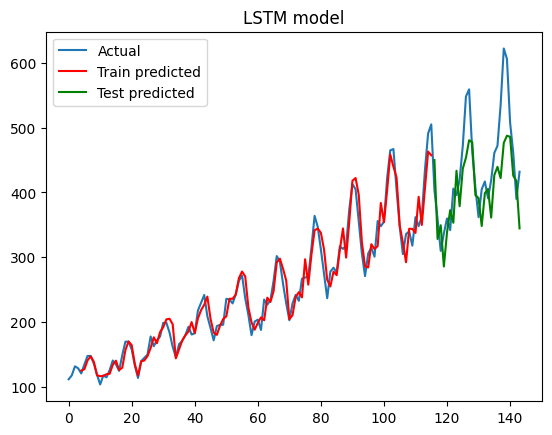

In [22]:
plot_model_results('LSTM model', df['Passengers'], train_preds_lstm, test_preds_lstm)

Model radzi sobie ze zmieniającymi się wartościami oraz proces uczenia przebiegł szybko

In [23]:
net_gru = GRU(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_gru.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_gru, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 1400 batches
[ 100,   13] train RMSE: 193.365, test RMSE: 389.328
[ 200,   13] train RMSE: 139.083, test RMSE: 326.243
[ 300,   13] train RMSE: 105.194, test RMSE: 280.606
[ 400,   13] train RMSE: 85.1872, test RMSE: 250.231
[ 500,   13] train RMSE: 71.4769, test RMSE: 227.082
[ 600,   13] train RMSE: 59.4397, test RMSE: 204.455
[ 700,   13] train RMSE: 49.7425, test RMSE: 183.596
[ 800,   13] train RMSE: 41.8348, test RMSE: 164.26
[ 900,   13] train RMSE: 36.1862, test RMSE: 147.222
[1000,   13] train RMSE: 31.8329, test RMSE: 131.885
[1100,   13] train RMSE: 29.1826, test RMSE: 118.581
[1200,   13] train RMSE: 26.8888, test RMSE: 107.271
[1300,   13] train RMSE: 24.872, test RMSE: 97.9429
[1400,   13] train RMSE: 23.6897, test RMSE: 90.5751
[1500,   13] train RMSE: 23.8996, test RMSE: 84.506
[1600,   13] train RMSE: 22.953, test RMSE: 81.8377
[1700,   13] train RMSE: 22.7247, test RMSE: 78.8048
[1800,   13] train RMSE: 22.285, test RMSE: 77.4953
[1900,   13] train RMSE: 2

In [24]:
train_predict_loss_gru, train_preds_gru = predict(net_gru, train_not_shuffle_loader, criterion)
test_predict_loss_gru, test_preds_gru = predict(net_gru, test_loader, criterion)

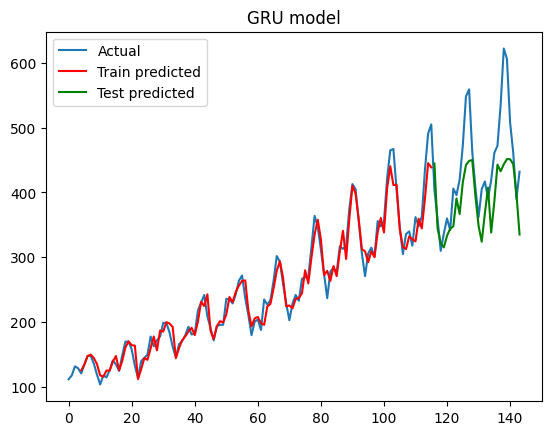

In [25]:
plot_model_results('GRU model', df['Passengers'], train_preds_gru, test_preds_gru)

Model GRU w tym przypadku też dobrze zadziałał, natomiast od niego oczekiwałem szybszego uczenia się, bo jest to jedna z jego zalet w stosunku do LSTM.

In [26]:
net_rnn = RNN(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_rnn.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_rnn, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 1400 batches
[ 100,   13] train RMSE: 189.917, test RMSE: 385.522
[ 200,   13] train RMSE: 131.113, test RMSE: 315.982
[ 300,   13] train RMSE: 102.757, test RMSE: 277.303
[ 400,   13] train RMSE: 85.2413, test RMSE: 250.658
[ 500,   13] train RMSE: 71.557, test RMSE: 227.603
[ 600,   13] train RMSE: 59.6414, test RMSE: 205.236
[ 700,   13] train RMSE: 49.9829, test RMSE: 184.8
[ 800,   13] train RMSE: 42.256, test RMSE: 166.047
[ 900,   13] train RMSE: 36.4372, test RMSE: 148.827
[1000,   13] train RMSE: 32.194, test RMSE: 133.99
[1100,   13] train RMSE: 29.8588, test RMSE: 120.748
[1200,   13] train RMSE: 27.1592, test RMSE: 109.154
[1300,   13] train RMSE: 25.5004, test RMSE: 99.791
[1400,   13] train RMSE: 24.1952, test RMSE: 92.0425
[1500,   13] train RMSE: 24.1462, test RMSE: 88.1141
[1600,   13] train RMSE: 23.5804, test RMSE: 82.5548
[1700,   13] train RMSE: 22.8955, test RMSE: 81.0044
[1800,   13] train RMSE: 22.3875, test RMSE: 78.7525
[1900,   13] train RMSE: 23.

In [27]:
train_predict_loss_rnn, train_preds_rnn = predict(net_rnn, train_not_shuffle_loader, criterion)
test_predict_loss_rnn, test_preds_rnn = predict(net_rnn, test_loader, criterion)

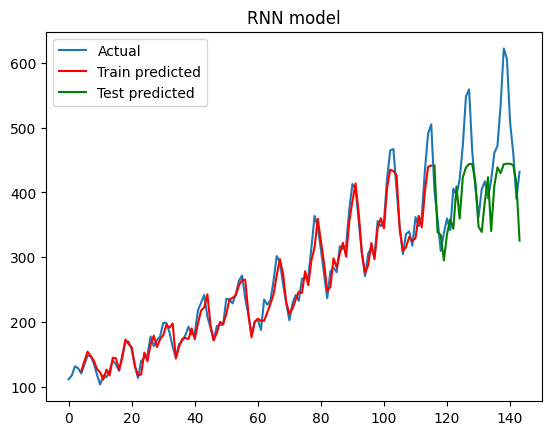

In [28]:
plot_model_results('RNN model', df['Passengers'], train_preds_rnn, test_preds_rnn)

Model RNN też potrafił się nauczyć, co naprowadza na myśl, że sposób w jaki tworzymy sekwencje przy tym laboratorium jest lepszy od tego z poprzedniego. (w sekwencji mamy +l wartości)

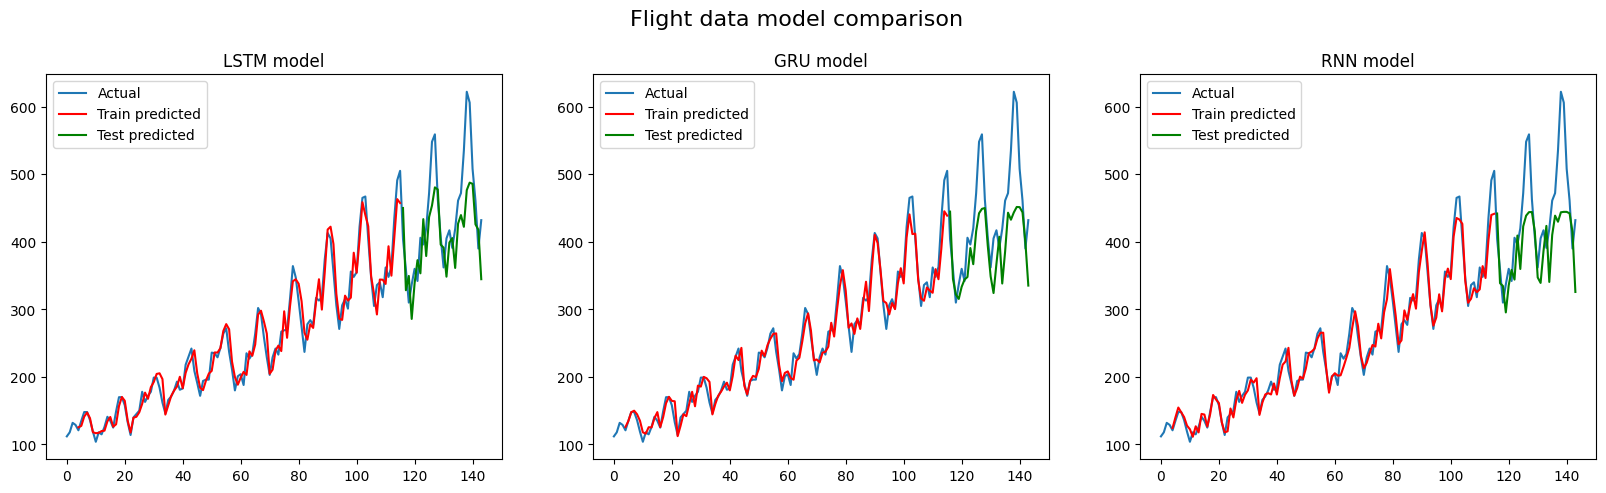

In [29]:
plot_all_results(
    "Flight data model comparison",
    lookback=4,
    actual=df['Passengers'].values,
    train_preds_lstm=train_preds_lstm,
    test_preds_lstm=test_preds_lstm,
    train_preds_gru=train_preds_gru,
    test_preds_gru=test_preds_gru,
    train_preds_rnn=train_preds_rnn,
    test_preds_rnn=test_preds_rnn
)

Tutaj widzimy porównanie 3 modeli w jednym miejscu. Jak widać najlepej się nauczył model LSTM natomiast RNN i GRU osiągnęły podobne wyniki. Wszystkie modele mają podobną wartość funkcji strat, natomiast troszeczkę mniejszy loss ma GRU.

<style>
div {
    color: orange;
}
</style>


Dla wszystkich pozostałych przypadków omawiany będzie tylko ten podsumowujący wykres.

### Zad 2

In [14]:
import yfinance as yf
import seaborn as sns
from datetime import date
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

In [15]:
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '1990-01-01'

In [16]:
batch_size = 1024
lookback = 50

In [17]:
def data_plot(df, title):
    df_plot = df.copy()

    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                           sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    fig.suptitle(title, fontsize=16, y=1.02)
    plt.show()

<style>
div {
    color: orange;
}
</style>

W pierwszej kolejności zostały użyte modele o tych samych parametrach, by móć do nich się odnosić, natomiast w kolejnej części są zastosowane inne.

##### AAPL

In [60]:
df = yf.download('AAPL', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [61]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263078,183198400
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264843,207995200
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265727,221513600
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266610,123312000
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268375,101572800


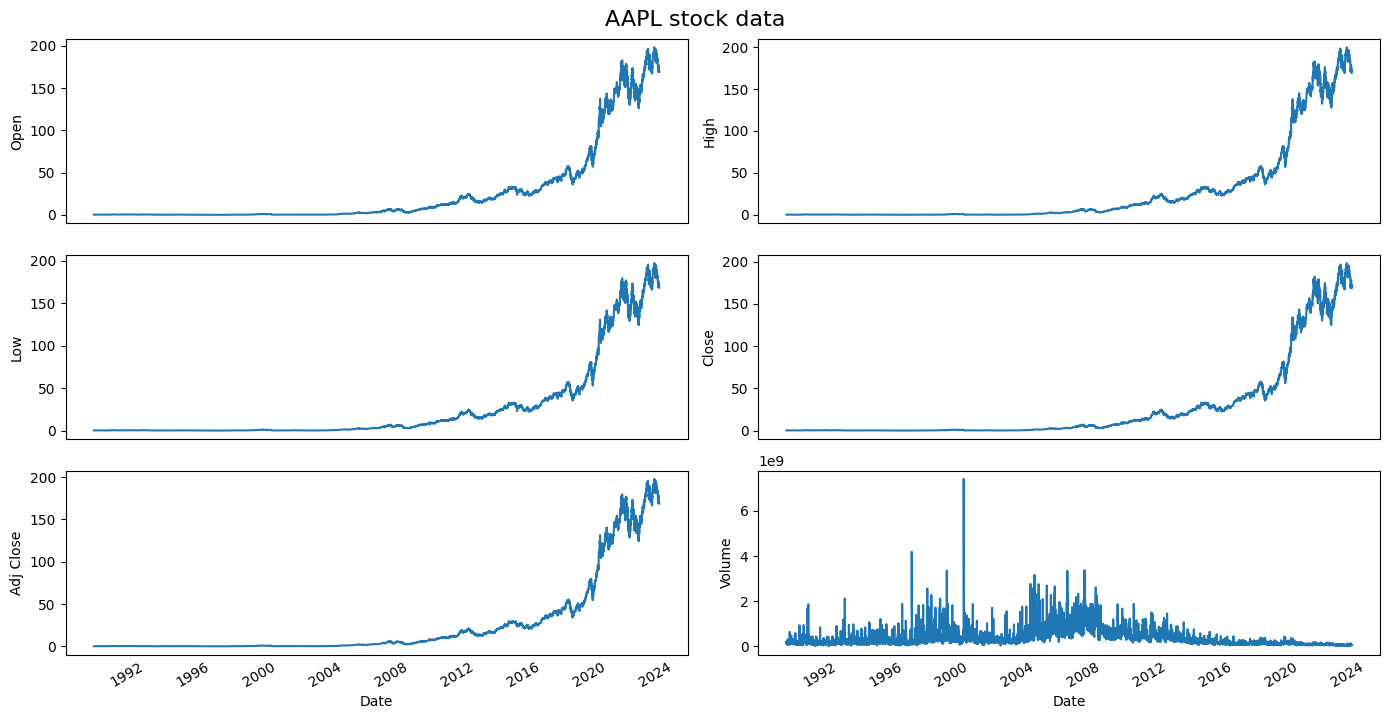

In [63]:
data_plot(df, 'AAPL stock data')

In [65]:
df['Open'].values.shape

(8628,)

In [66]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Open'].values.reshape(-1, 1))

In [67]:
ds = FunctionDataset(scaled_data, lookback=lookback, split_ratio=0.8)

train_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=True, batch_size=batch_size)
train_not_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=False, batch_size=batch_size)
test_loader = data.DataLoader(ds.get_test_ds(), shuffle=False, batch_size=batch_size)

[Dataset]: total samples 8628, sequence length 50, total sequences 8578, split ratio 0.8, train 6862, test 1716


In [68]:
len(train_shuffle_loader), len(test_loader)

(7, 2)

In [69]:
# get the first batch

X, y = next(iter(train_shuffle_loader))

X.shape, y.shape

(torch.Size([1024, 50, 1]), torch.Size([1024, 50, 1]))

In [70]:
net_lstm = LSTM(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_lstm.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_lstm, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 700 batches
[ 100,    6] train RMSE: 0.0053397, test RMSE: 0.0678569
[ 200,    6] train RMSE: 0.00247842, test RMSE: 0.0323555
[ 300,    6] train RMSE: 0.00126419, test RMSE: 0.0182709
[ 400,    6] train RMSE: 0.00106066, test RMSE: 0.0176472
[ 500,    6] train RMSE: 0.00234831, test RMSE: 0.0188384
[ 600,    6] train RMSE: 0.00105111, test RMSE: 0.0175298
[ 700,    6] train RMSE: 0.00102121, test RMSE: 0.0178254
[ 800,    6] train RMSE: 0.00104552, test RMSE: 0.0183204
[ 900,    6] train RMSE: 0.00104846, test RMSE: 0.0183416
[1000,    6] train RMSE: 0.00101372, test RMSE: 0.0188587
[1100,    6] train RMSE: 0.00161094, test RMSE: 0.0191406
[1200,    6] train RMSE: 0.00102051, test RMSE: 0.0199121
[1300,    6] train RMSE: 0.00106964, test RMSE: 0.0201227
[1400,    6] train RMSE: 0.00103618, test RMSE: 0.0213455
[1500,    6] train RMSE: 0.00110781, test RMSE: 0.0223488
[1600,    6] train RMSE: 0.00102763, test RMSE: 0.0224163
[1700,    6] train RMSE: 0.00101543, test RMSE: 0

In [71]:
train_predict_loss_lstm, train_preds_lstm = predict(net_lstm, train_not_shuffle_loader, criterion)
test_predict_loss_lstm, test_preds_lstm = predict(net_lstm, test_loader, criterion)

In [72]:
train_preds_lstm.shape,test_preds_lstm.shape, df['Open'].shape, 

((6862,), (1716,), (8628,))

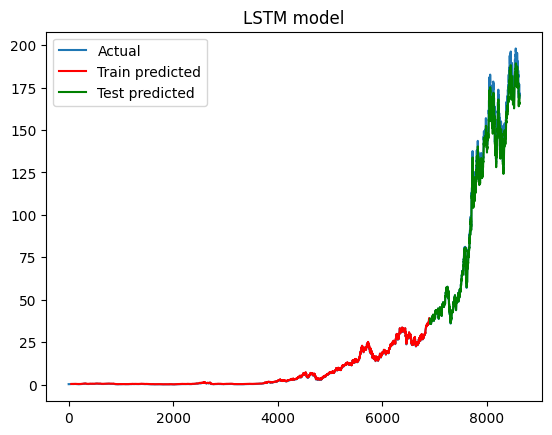

In [73]:
plot_model_results(
    title='LSTM model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_lstm.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_lstm.reshape(-1, 1)).flatten(),
    lookback=lookback
)

In [74]:
net_gru = GRU(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_gru.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_gru, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 700 batches
[ 100,    6] train RMSE: 0.00389961, test RMSE: 0.0522044
[ 200,    6] train RMSE: 0.00201702, test RMSE: 0.027891
[ 300,    6] train RMSE: 0.00121557, test RMSE: 0.0151541
[ 400,    6] train RMSE: 0.00103363, test RMSE: 0.0139664
[ 500,    6] train RMSE: 0.00102335, test RMSE: 0.0137838
[ 600,    6] train RMSE: 0.00101968, test RMSE: 0.0136618
[ 700,    6] train RMSE: 0.00102023, test RMSE: 0.0134219
[ 800,    6] train RMSE: 0.00101875, test RMSE: 0.0134796
[ 900,    6] train RMSE: 0.00108035, test RMSE: 0.0135599
[1000,    6] train RMSE: 0.00125502, test RMSE: 0.0131687
[1100,    6] train RMSE: 0.00172714, test RMSE: 0.014313
[1200,    6] train RMSE: 0.00129226, test RMSE: 0.0136572
[1300,    6] train RMSE: 0.0013836, test RMSE: 0.0134508
[1400,    6] train RMSE: 0.00100961, test RMSE: 0.0140434
[1500,    6] train RMSE: 0.00103748, test RMSE: 0.0146708
[1600,    6] train RMSE: 0.00106431, test RMSE: 0.0148496
[1700,    6] train RMSE: 0.00106734, test RMSE: 0.0

In [75]:
train_predict_loss_gru, train_preds_gru = predict(net_gru, train_not_shuffle_loader, criterion)
test_predict_loss_gru, test_preds_gru = predict(net_gru, test_loader, criterion)

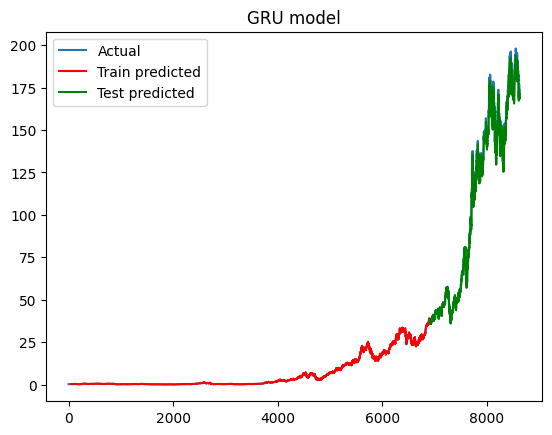

In [76]:
plot_model_results(
    title='GRU model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_gru.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_gru.reshape(-1, 1)).flatten(),
    lookback=lookback
)

In [77]:
net_rnn = RNN(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_rnn.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_rnn, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 700 batches
[ 100,    6] train RMSE: 0.00312402, test RMSE: 0.0433081
[ 200,    6] train RMSE: 0.00164052, test RMSE: 0.0244335
[ 300,    6] train RMSE: 0.00155541, test RMSE: 0.0169733
[ 400,    6] train RMSE: 0.00101703, test RMSE: 0.0168728
[ 500,    6] train RMSE: 0.00227806, test RMSE: 0.0186195
[ 600,    6] train RMSE: 0.00102096, test RMSE: 0.0179657
[ 700,    6] train RMSE: 0.00211466, test RMSE: 0.0202195
[ 800,    6] train RMSE: 0.00194201, test RMSE: 0.0208007
[ 900,    6] train RMSE: 0.00103992, test RMSE: 0.0204936
[1000,    6] train RMSE: 0.00107267, test RMSE: 0.0208783
[1100,    6] train RMSE: 0.00231024, test RMSE: 0.0226508
[1200,    6] train RMSE: 0.00101543, test RMSE: 0.0217642
[1300,    6] train RMSE: 0.00101531, test RMSE: 0.0231864
[1400,    6] train RMSE: 0.00101929, test RMSE: 0.0233263
[1500,    6] train RMSE: 0.00181902, test RMSE: 0.0240578
[1600,    6] train RMSE: 0.00104889, test RMSE: 0.0255224
[1700,    6] train RMSE: 0.00101861, test RMSE: 

In [78]:
train_predict_loss_rnn, train_preds_rnn = predict(net_rnn, train_not_shuffle_loader, criterion)
test_predict_loss_rnn, test_preds_rnn = predict(net_rnn, test_loader, criterion)

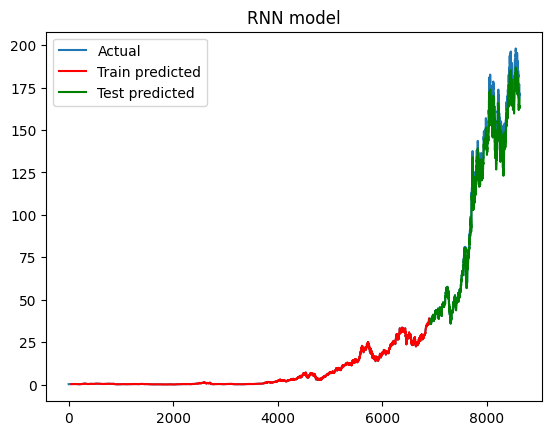

In [79]:
plot_model_results(
    title='RNN model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_rnn.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_rnn.reshape(-1, 1)).flatten(),
    lookback=lookback
)

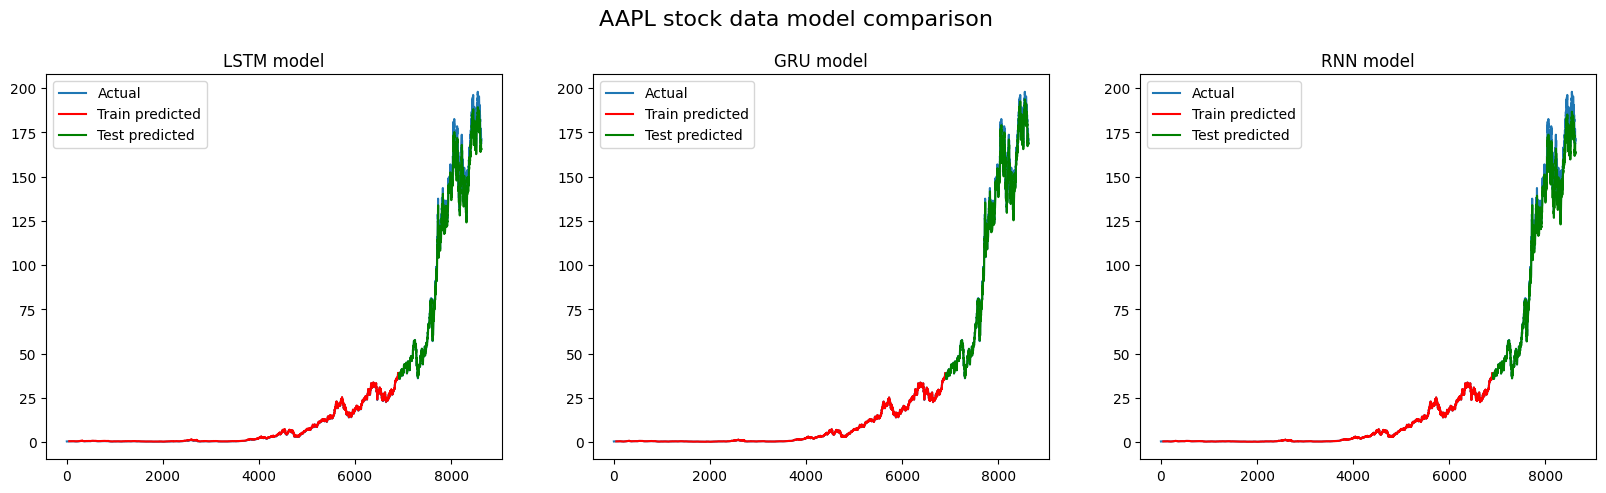

In [80]:
plot_all_results(
    title='AAPL stock data model comparison',
    lookback=lookback, 
    actual=df['Open'].values,
    train_preds_lstm=scaler.inverse_transform(train_preds_lstm.reshape(-1, 1)).flatten(), 
    test_preds_lstm=scaler.inverse_transform(test_preds_lstm.reshape(-1, 1)).flatten(),
    train_preds_gru=scaler.inverse_transform(train_preds_gru.reshape(-1, 1)).flatten(), 
    test_preds_gru=scaler.inverse_transform(test_preds_gru.reshape(-1, 1)).flatten(),
    train_preds_rnn=scaler.inverse_transform(train_preds_rnn.reshape(-1, 1)).flatten(), 
    test_preds_rnn=scaler.inverse_transform(test_preds_rnn.reshape(-1, 1)).flatten()
)

Tutuaj wszystkie modele mają dobre wyniki, natomiast najlepeij wyszedł model GRU, ma najmniejszy loss, a też z wykresu widać, że praktycznie nie widać niebieskiego koloru. Tutaj model GRU uczył się ponad minutę mniej, co jest jego zaletą w związku z uproszczoną strukturę, ale i tak RNN nauczył się znacznie szybciej.

##### GOOG

In [81]:
df = yf.download('GOOG', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [82]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-03-27,28.322241,28.322241,27.570307,27.846546,27.846546,262719
2014-03-28,27.983171,28.243956,27.857019,27.922838,27.922838,824257
2014-03-31,28.266893,28.272379,27.770258,27.772251,27.772251,216593
2014-04-01,27.859013,28.344681,27.859013,28.280355,28.280355,158434
2014-04-02,29.917362,30.158699,28.032537,28.272379,28.272379,2942055


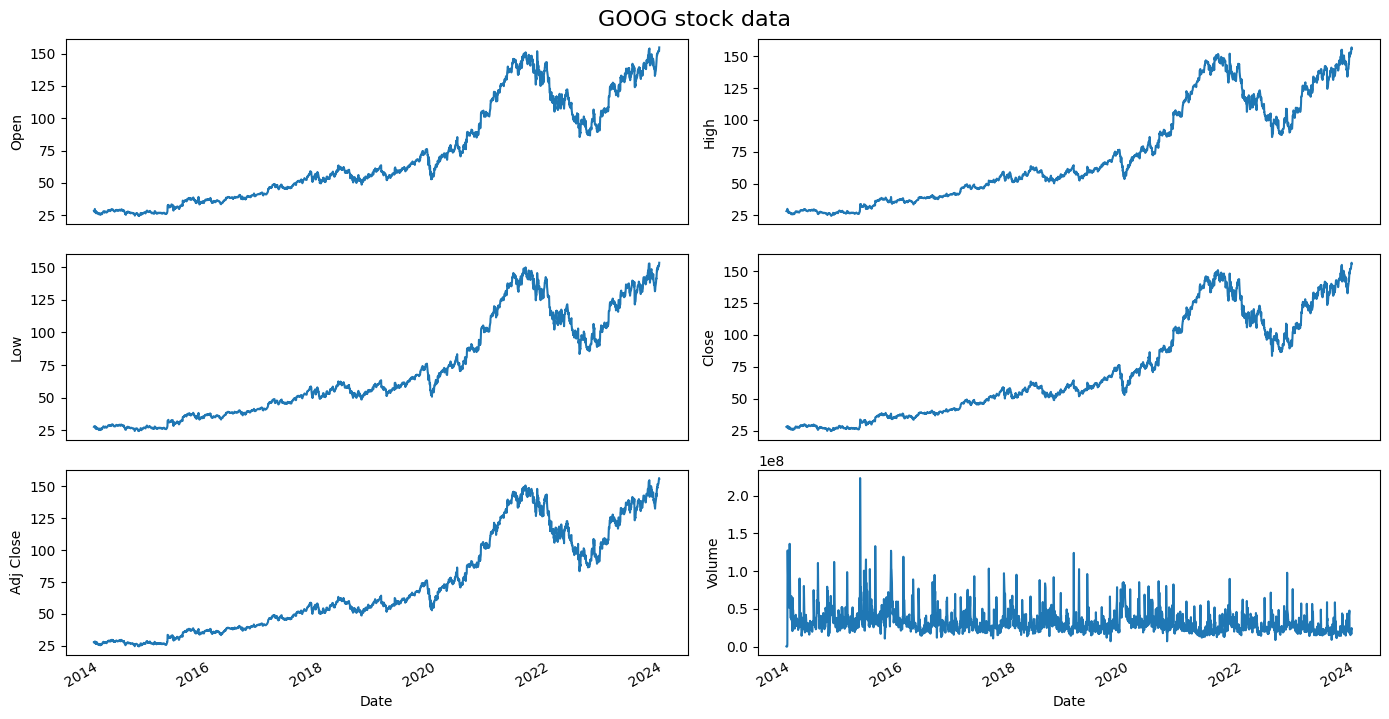

In [83]:
data_plot(df, 'GOOG stock data')

In [84]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Open'].values.reshape(-1, 1))

In [85]:
ds = FunctionDataset(scaled_data, lookback=lookback, split_ratio=0.8)

train_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=True, batch_size=batch_size)
train_not_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=False, batch_size=batch_size)
test_loader = data.DataLoader(ds.get_test_ds(), shuffle=False, batch_size=batch_size)

[Dataset]: total samples 2521, sequence length 50, total sequences 2471, split ratio 0.8, train 1976, test 495


In [86]:
net_lstm = LSTM(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_lstm.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_lstm, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 200 batches
[ 100,    1] train RMSE: 0.0648721, test RMSE: 0.13131
[ 200,    1] train RMSE: 0.0450548, test RMSE: 0.0916035
[ 300,    1] train RMSE: 0.0319314, test RMSE: 0.0644763
[ 400,    1] train RMSE: 0.0226537, test RMSE: 0.0441551
[ 500,    1] train RMSE: 0.0174288, test RMSE: 0.0321551
[ 600,    1] train RMSE: 0.0138826, test RMSE: 0.0255873
[ 700,    1] train RMSE: 0.0112097, test RMSE: 0.0211489
[ 800,    1] train RMSE: 0.00969326, test RMSE: 0.0187518
[ 900,    1] train RMSE: 0.00917003, test RMSE: 0.017966
[1000,    1] train RMSE: 0.00903789, test RMSE: 0.017816
[1100,    1] train RMSE: 0.00898379, test RMSE: 0.0178009
[1200,    1] train RMSE: 0.00896307, test RMSE: 0.0178538
[1300,    1] train RMSE: 0.00912731, test RMSE: 0.0182491
[1400,    1] train RMSE: 0.00894565, test RMSE: 0.0178655
[1500,    1] train RMSE: 0.00906021, test RMSE: 0.0177553
[1600,    1] train RMSE: 0.00899792, test RMSE: 0.0177582
[1700,    1] train RMSE: 0.00897986, test RMSE: 0.018041
[1

In [87]:
train_predict_loss_lstm, train_preds_lstm = predict(net_lstm, train_not_shuffle_loader, criterion)
test_predict_loss_lstm, test_preds_lstm = predict(net_lstm, test_loader, criterion)

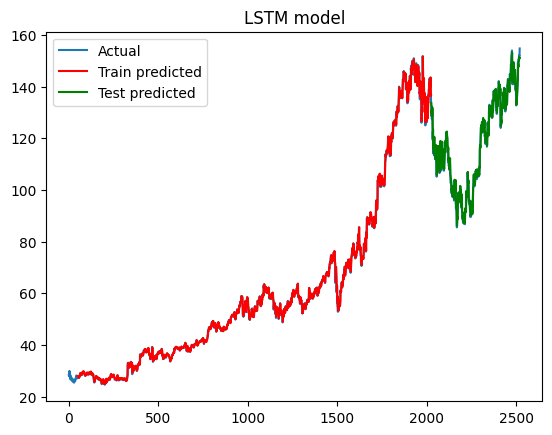

In [88]:
plot_model_results(
    title='LSTM model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_lstm.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_lstm.reshape(-1, 1)).flatten(),
    lookback=lookback
)

In [89]:
net_gru = GRU(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_gru.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_gru, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 200 batches
[ 100,    1] train RMSE: 0.0402176, test RMSE: 0.0812739
[ 200,    1] train RMSE: 0.0286576, test RMSE: 0.0581145
[ 300,    1] train RMSE: 0.0220804, test RMSE: 0.0438057
[ 400,    1] train RMSE: 0.0178528, test RMSE: 0.034456
[ 500,    1] train RMSE: 0.014891, test RMSE: 0.0280559
[ 600,    1] train RMSE: 0.012892, test RMSE: 0.0239157
[ 700,    1] train RMSE: 0.0113897, test RMSE: 0.0212544
[ 800,    1] train RMSE: 0.0103201, test RMSE: 0.0195236
[ 900,    1] train RMSE: 0.00963484, test RMSE: 0.0185077
[1000,    1] train RMSE: 0.00926864, test RMSE: 0.0180075
[1100,    1] train RMSE: 0.00911775, test RMSE: 0.0178177
[1200,    1] train RMSE: 0.00904122, test RMSE: 0.0177673
[1300,    1] train RMSE: 0.00903834, test RMSE: 0.0177549
[1400,    1] train RMSE: 0.00901754, test RMSE: 0.0177631
[1500,    1] train RMSE: 0.00902263, test RMSE: 0.0177559
[1600,    1] train RMSE: 0.00901408, test RMSE: 0.017737
[1700,    1] train RMSE: 0.0090172, test RMSE: 0.0177377
[18

In [90]:
train_predict_loss_gru, train_preds_gru = predict(net_gru, train_not_shuffle_loader, criterion)
test_predict_loss_gru, test_preds_gru = predict(net_gru, test_loader, criterion)

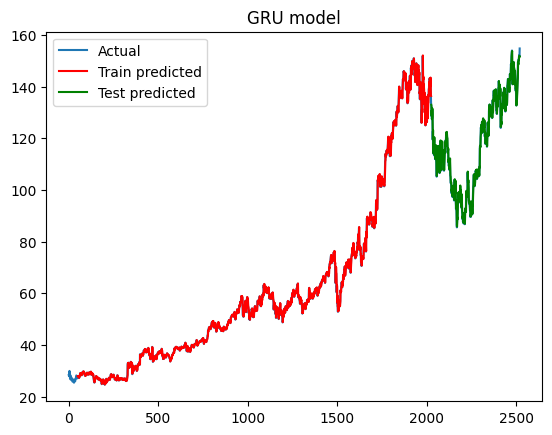

In [91]:
plot_model_results(
    title='GRU model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_gru.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_gru.reshape(-1, 1)).flatten(),
    lookback=lookback
)

In [92]:
net_rnn = RNN(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_rnn.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_rnn, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 200 batches
[ 100,    1] train RMSE: 0.0362392, test RMSE: 0.0722989
[ 200,    1] train RMSE: 0.026291, test RMSE: 0.052094
[ 300,    1] train RMSE: 0.0206465, test RMSE: 0.0396012
[ 400,    1] train RMSE: 0.0170033, test RMSE: 0.0320199
[ 500,    1] train RMSE: 0.0141802, test RMSE: 0.0268071
[ 600,    1] train RMSE: 0.0119125, test RMSE: 0.0228345
[ 700,    1] train RMSE: 0.0103158, test RMSE: 0.0200469
[ 800,    1] train RMSE: 0.00943204, test RMSE: 0.0185207
[ 900,    1] train RMSE: 0.00909946, test RMSE: 0.0179392
[1000,    1] train RMSE: 0.00901049, test RMSE: 0.0177679
[1100,    1] train RMSE: 0.00899213, test RMSE: 0.0177259
[1200,    1] train RMSE: 0.00897466, test RMSE: 0.0177289
[1300,    1] train RMSE: 0.0089908, test RMSE: 0.0177291
[1400,    1] train RMSE: 0.00898695, test RMSE: 0.0177293
[1500,    1] train RMSE: 0.00898694, test RMSE: 0.0177175
[1600,    1] train RMSE: 0.00897707, test RMSE: 0.0177171
[1700,    1] train RMSE: 0.0089811, test RMSE: 0.0177529
[

In [93]:
train_predict_loss_rnn, train_preds_rnn = predict(net_rnn, train_not_shuffle_loader, criterion)
test_predict_loss_rnn, test_preds_rnn = predict(net_rnn, test_loader, criterion)

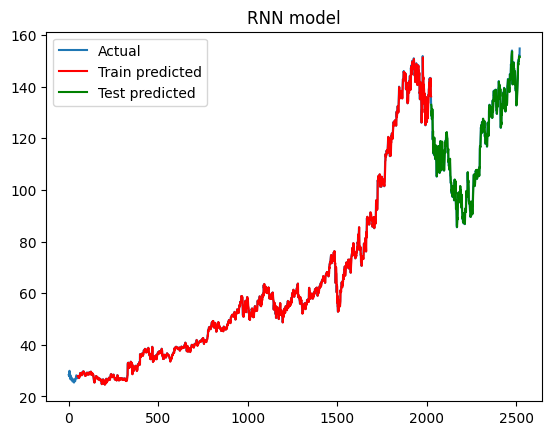

In [94]:
plot_model_results(
    title='RNN model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_rnn.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_rnn.reshape(-1, 1)).flatten(),
    lookback=lookback
)

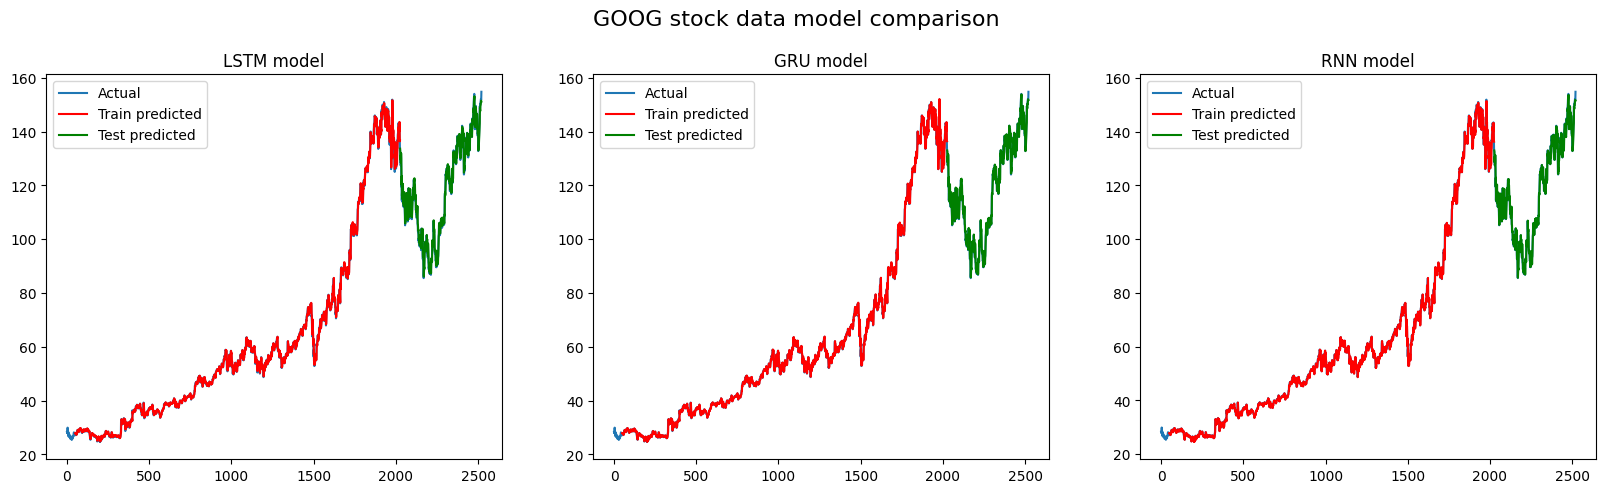

In [95]:
plot_all_results(
    title='GOOG stock data model comparison',
    lookback=lookback, 
    actual=df['Open'].values,
    train_preds_lstm=scaler.inverse_transform(train_preds_lstm.reshape(-1, 1)).flatten(), 
    test_preds_lstm=scaler.inverse_transform(test_preds_lstm.reshape(-1, 1)).flatten(),
    train_preds_gru=scaler.inverse_transform(train_preds_gru.reshape(-1, 1)).flatten(), 
    test_preds_gru=scaler.inverse_transform(test_preds_gru.reshape(-1, 1)).flatten(),
    train_preds_rnn=scaler.inverse_transform(train_preds_rnn.reshape(-1, 1)).flatten(), 
    test_preds_rnn=scaler.inverse_transform(test_preds_rnn.reshape(-1, 1)).flatten()
)

Tutaj każdy model osiągnął bardzo podobne wyniki oraz praktycznie identyczny loss, natomiast RNN, jak i w poprzednim przypadku nauczył się o wiele szybciej.

##### AMZN

In [96]:
df = yf.download('AMZN', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [97]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


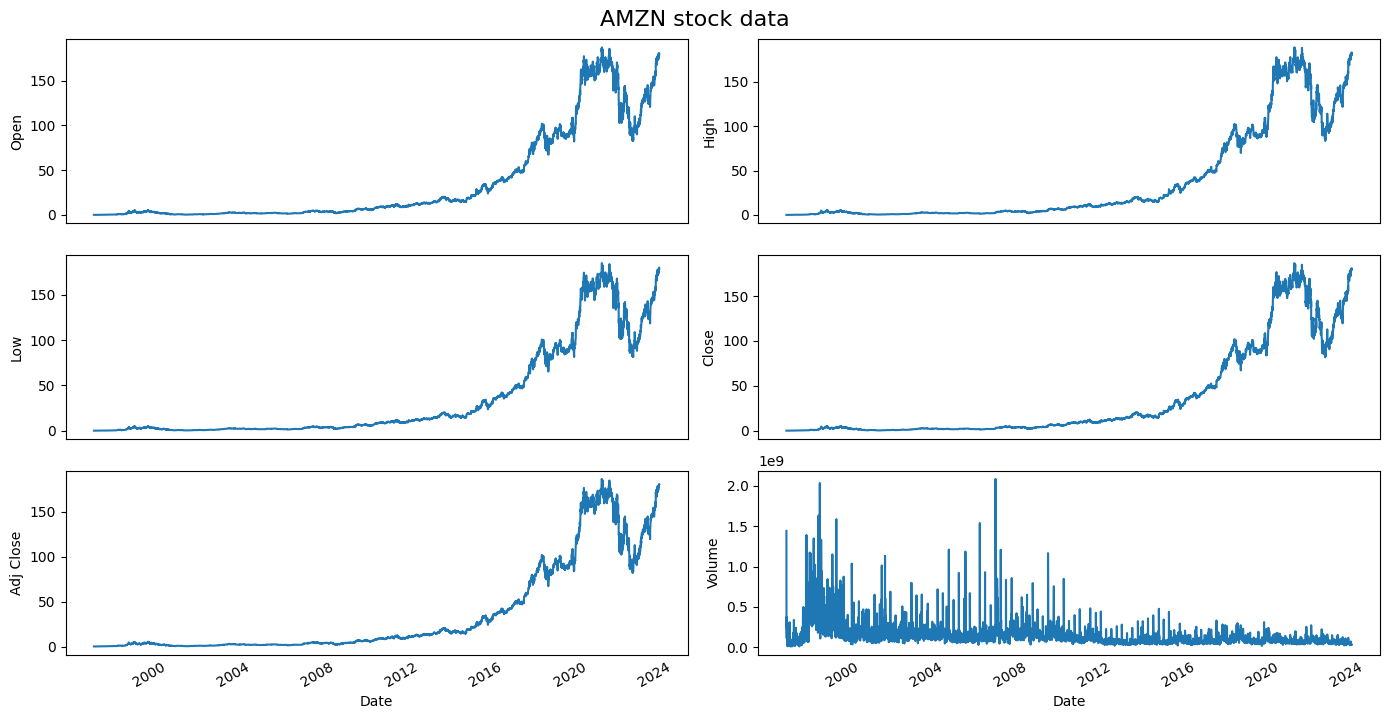

In [98]:
data_plot(df, 'AMZN stock data')

In [99]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Open'].values.reshape(-1, 1))

In [100]:
ds = FunctionDataset(scaled_data, lookback=lookback, split_ratio=0.8)

train_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=True, batch_size=batch_size)
train_not_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=False, batch_size=batch_size)
test_loader = data.DataLoader(ds.get_test_ds(), shuffle=False, batch_size=batch_size)

[Dataset]: total samples 6764, sequence length 50, total sequences 6714, split ratio 0.8, train 5371, test 1343


In [101]:
net_lstm = LSTM(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_lstm.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_lstm, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 600 batches
[ 100,    5] train RMSE: 0.0133259, test RMSE: 0.0831583
[ 200,    5] train RMSE: 0.00817217, test RMSE: 0.0502421
[ 300,    5] train RMSE: 0.00471616, test RMSE: 0.0289336
[ 400,    5] train RMSE: 0.00265916, test RMSE: 0.0162178
[ 500,    5] train RMSE: 0.00230368, test RMSE: 0.0153531
[ 600,    5] train RMSE: 0.00227702, test RMSE: 0.0155347
[ 700,    5] train RMSE: 0.00227626, test RMSE: 0.0158563
[ 800,    5] train RMSE: 0.00223359, test RMSE: 0.0159445
[ 900,    5] train RMSE: 0.00238851, test RMSE: 0.0159548
[1000,    5] train RMSE: 0.0021947, test RMSE: 0.0168268
[1100,    5] train RMSE: 0.00222417, test RMSE: 0.0168367
[1200,    5] train RMSE: 0.00219407, test RMSE: 0.0174233
[1300,    5] train RMSE: 0.00231532, test RMSE: 0.0180719
[1400,    5] train RMSE: 0.00235465, test RMSE: 0.0190231
[1500,    5] train RMSE: 0.00223422, test RMSE: 0.0183309
[1600,    5] train RMSE: 0.00219001, test RMSE: 0.0189337
[1700,    5] train RMSE: 0.00227424, test RMSE: 0.

In [102]:
train_predict_loss_lstm, train_preds_lstm = predict(net_lstm, train_not_shuffle_loader, criterion)
test_predict_loss_lstm, test_preds_lstm = predict(net_lstm, test_loader, criterion)

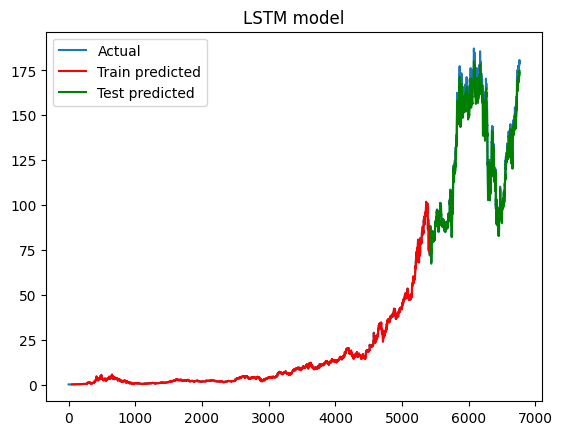

In [103]:
plot_model_results(
    title='LSTM model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_lstm.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_lstm.reshape(-1, 1)).flatten(),
    lookback=lookback
)

In [104]:
net_gru = GRU(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_gru.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_gru, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 600 batches
[ 100,    5] train RMSE: 0.00995585, test RMSE: 0.0598278
[ 200,    5] train RMSE: 0.00573719, test RMSE: 0.0355084
[ 300,    5] train RMSE: 0.00364775, test RMSE: 0.0226971
[ 400,    5] train RMSE: 0.00252262, test RMSE: 0.0165099
[ 500,    5] train RMSE: 0.00233329, test RMSE: 0.015584
[ 600,    5] train RMSE: 0.00224907, test RMSE: 0.0155865
[ 700,    5] train RMSE: 0.00227531, test RMSE: 0.015481
[ 800,    5] train RMSE: 0.00227486, test RMSE: 0.0154105
[ 900,    5] train RMSE: 0.00229149, test RMSE: 0.0155844
[1000,    5] train RMSE: 0.00225925, test RMSE: 0.015469
[1100,    5] train RMSE: 0.00218209, test RMSE: 0.0154239
[1200,    5] train RMSE: 0.00221577, test RMSE: 0.0152755
[1300,    5] train RMSE: 0.00221793, test RMSE: 0.0154038
[1400,    5] train RMSE: 0.00227333, test RMSE: 0.0154312
[1500,    5] train RMSE: 0.00222242, test RMSE: 0.0153088
[1600,    5] train RMSE: 0.00223282, test RMSE: 0.015188
[1700,    5] train RMSE: 0.00218519, test RMSE: 0.01

In [105]:
train_predict_loss_gru, train_preds_gru = predict(net_gru, train_not_shuffle_loader, criterion)
test_predict_loss_gru, test_preds_gru = predict(net_gru, test_loader, criterion)

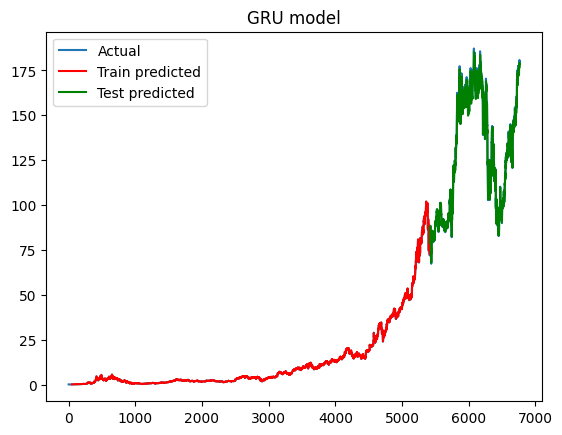

In [106]:
plot_model_results(
    title='GRU model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_gru.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_gru.reshape(-1, 1)).flatten(),
    lookback=lookback
)

In [107]:
net_rnn = RNN(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_rnn.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_rnn, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 600 batches
[ 100,    5] train RMSE: 0.00883683, test RMSE: 0.0579649
[ 200,    5] train RMSE: 0.00401736, test RMSE: 0.0275606
[ 300,    5] train RMSE: 0.00228167, test RMSE: 0.0167663
[ 400,    5] train RMSE: 0.00226219, test RMSE: 0.0161126
[ 500,    5] train RMSE: 0.00237175, test RMSE: 0.0163871
[ 600,    5] train RMSE: 0.00223554, test RMSE: 0.0162116
[ 700,    5] train RMSE: 0.00224814, test RMSE: 0.0162837
[ 800,    5] train RMSE: 0.00230261, test RMSE: 0.0160925
[ 900,    5] train RMSE: 0.00237635, test RMSE: 0.0166488
[1000,    5] train RMSE: 0.00225914, test RMSE: 0.0166974
[1100,    5] train RMSE: 0.00228031, test RMSE: 0.0166341
[1200,    5] train RMSE: 0.00324798, test RMSE: 0.0169059
[1300,    5] train RMSE: 0.00222362, test RMSE: 0.0165976
[1400,    5] train RMSE: 0.00230779, test RMSE: 0.0169441
[1500,    5] train RMSE: 0.00228443, test RMSE: 0.0167185
[1600,    5] train RMSE: 0.00223203, test RMSE: 0.016945
[1700,    5] train RMSE: 0.00226017, test RMSE: 0

In [108]:
train_predict_loss_rnn, train_preds_rnn = predict(net_rnn, train_not_shuffle_loader, criterion)
test_predict_loss_rnn, test_preds_rnn = predict(net_rnn, test_loader, criterion)

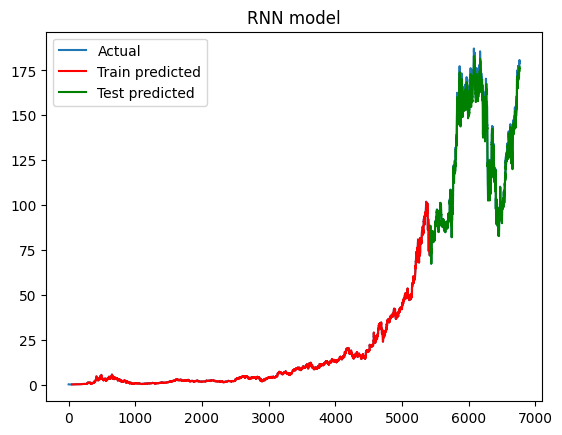

In [109]:
plot_model_results(
    title='RNN model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_rnn.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_rnn.reshape(-1, 1)).flatten(),
    lookback=lookback
)

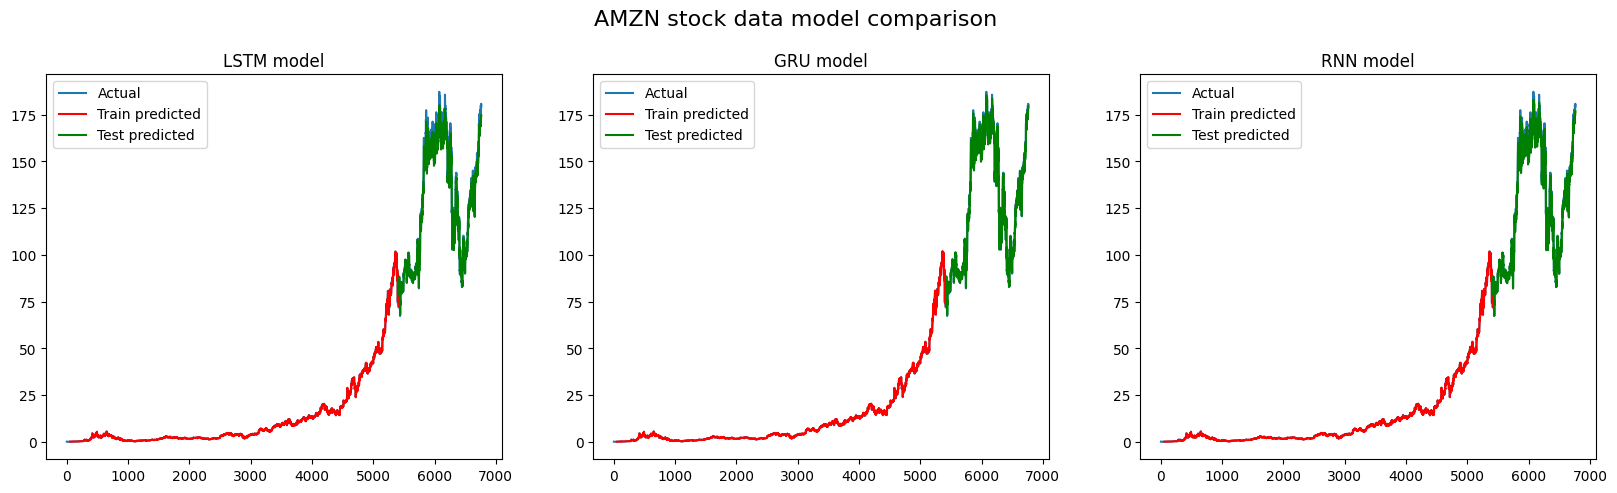

In [110]:
plot_all_results(
    title='AMZN stock data model comparison',
    lookback=lookback, 
    actual=df['Open'].values,
    train_preds_lstm=scaler.inverse_transform(train_preds_lstm.reshape(-1, 1)).flatten(), 
    test_preds_lstm=scaler.inverse_transform(test_preds_lstm.reshape(-1, 1)).flatten(),
    train_preds_gru=scaler.inverse_transform(train_preds_gru.reshape(-1, 1)).flatten(), 
    test_preds_gru=scaler.inverse_transform(test_preds_gru.reshape(-1, 1)).flatten(),
    train_preds_rnn=scaler.inverse_transform(train_preds_rnn.reshape(-1, 1)).flatten(), 
    test_preds_rnn=scaler.inverse_transform(test_preds_rnn.reshape(-1, 1)).flatten()
)

Wnioski z poprzednich punktów są prawdziwe i tutaj, natomiast patrząć na wykresy wybrałbym model GRU.

<style>
div {
    color: orange;
}
</style>

Patrząc na te wyniki ciągle widziałem, że train loss jest o rząd niższy od validation. Różnicę między nimi można potraktować jako miarę przeuczenia, co w dalszej części probuję optymalizować.

##### AAPL RMSprop

In [18]:
epochs = 1000

In [19]:
df = yf.download('AAPL', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Open'].values.reshape(-1, 1))

In [21]:
ds = FunctionDataset(scaled_data, lookback=lookback, split_ratio=0.8)

train_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=True, batch_size=batch_size)
train_not_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=False, batch_size=batch_size)
test_loader = data.DataLoader(ds.get_test_ds(), shuffle=False, batch_size=batch_size)

[Dataset]: total samples 8628, sequence length 50, total sequences 8578, split ratio 0.8, train 6862, test 1716


In [22]:
net_lstm = LSTM(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.RMSprop(net_lstm.parameters(), lr=0.001609537487168266)
criterion = nn.MSELoss()

learning_time = train(net_lstm, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 350 batches
[  50,    6] train RMSE: 0.00920801, test RMSE: 0.200179
[ 100,    6] train RMSE: 0.00721184, test RMSE: 0.0863778
[ 150,    6] train RMSE: 0.00475131, test RMSE: 0.0661063
[ 200,    6] train RMSE: 0.0053171, test RMSE: 0.0553779
[ 250,    6] train RMSE: 0.00423314, test RMSE: 0.0387456
[ 300,    6] train RMSE: 0.00473018, test RMSE: 0.0244617
[ 350,    6] train RMSE: 0.00377622, test RMSE: 0.0176796
[ 400,    6] train RMSE: 0.00294803, test RMSE: 0.0193658
[ 450,    6] train RMSE: 0.00386294, test RMSE: 0.0270032
[ 500,    6] train RMSE: 0.0042501, test RMSE: 0.0379331
[ 550,    6] train RMSE: 0.00347899, test RMSE: 0.0455801
[ 600,    6] train RMSE: 0.00223335, test RMSE: 0.0545718
[ 650,    6] train RMSE: 0.00354002, test RMSE: 0.0603744
[ 700,    6] train RMSE: 0.00273008, test RMSE: 0.0696615
[ 750,    6] train RMSE: 0.00237417, test RMSE: 0.0738311
[ 800,    6] train RMSE: 0.00296309, test RMSE: 0.0776326
[ 850,    6] train RMSE: 0.00225719, test RMSE: 0.0

In [23]:
train_predict_loss_lstm, train_preds_lstm = predict(net_lstm, train_not_shuffle_loader, criterion)
test_predict_loss_lstm, test_preds_lstm = predict(net_lstm, test_loader, criterion)

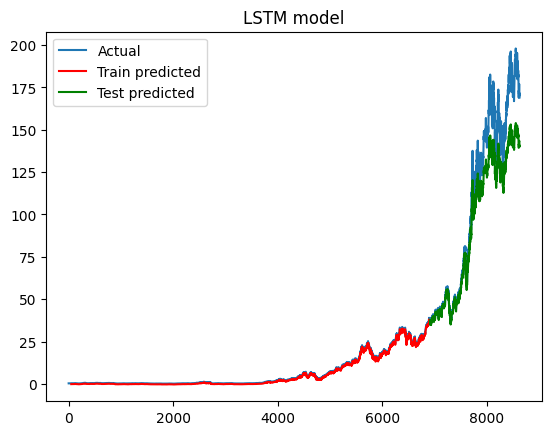

In [24]:
plot_model_results(
    title='LSTM model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_lstm.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_lstm.reshape(-1, 1)).flatten(),
    lookback=lookback
)

In [25]:
net_gru = GRU(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.RMSprop(net_lstm.parameters(), lr=0.001609537487168266)
criterion = nn.MSELoss()

learning_time = train(net_gru, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 350 batches
[  50,    6] train RMSE: 0.156325, test RMSE: 0.769175
[ 100,    6] train RMSE: 0.156278, test RMSE: 0.769175
[ 150,    6] train RMSE: 0.156182, test RMSE: 0.769175
[ 200,    6] train RMSE: 0.156456, test RMSE: 0.769175
[ 250,    6] train RMSE: 0.156345, test RMSE: 0.769175
[ 300,    6] train RMSE: 0.156359, test RMSE: 0.769175
[ 350,    6] train RMSE: 0.156111, test RMSE: 0.769175
[ 400,    6] train RMSE: 0.156284, test RMSE: 0.769175
[ 450,    6] train RMSE: 0.156337, test RMSE: 0.769175
[ 500,    6] train RMSE: 0.156265, test RMSE: 0.769175
[ 550,    6] train RMSE: 0.156176, test RMSE: 0.769175
[ 600,    6] train RMSE: 0.156318, test RMSE: 0.769175
[ 650,    6] train RMSE: 0.156442, test RMSE: 0.769175
[ 700,    6] train RMSE: 0.156412, test RMSE: 0.769175
[ 750,    6] train RMSE: 0.15634, test RMSE: 0.769175
[ 800,    6] train RMSE: 0.15639, test RMSE: 0.769175
[ 850,    6] train RMSE: 0.156372, test RMSE: 0.769175
[ 900,    6] train RMSE: 0.156342, test RMS

In [26]:
train_predict_loss_gru, train_preds_gru = predict(net_gru, train_not_shuffle_loader, criterion)
test_predict_loss_gru, test_preds_gru = predict(net_gru, test_loader, criterion)

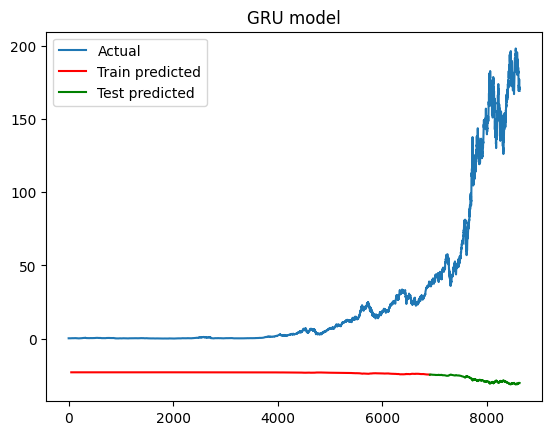

In [27]:
plot_model_results(
    title='GRU model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_gru.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_gru.reshape(-1, 1)).flatten(),
    lookback=lookback
)

In [28]:
net_rnn = RNN(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.RMSprop(net_lstm.parameters(), lr=0.001609537487168266)
criterion = nn.MSELoss()

learning_time = train(net_rnn, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 350 batches
[  50,    6] train RMSE: 0.073437, test RMSE: 0.621981
[ 100,    6] train RMSE: 0.0736789, test RMSE: 0.621981
[ 150,    6] train RMSE: 0.0735749, test RMSE: 0.621981
[ 200,    6] train RMSE: 0.073639, test RMSE: 0.621981
[ 250,    6] train RMSE: 0.0736243, test RMSE: 0.621981
[ 300,    6] train RMSE: 0.0734656, test RMSE: 0.621981
[ 350,    6] train RMSE: 0.0734811, test RMSE: 0.621981
[ 400,    6] train RMSE: 0.0735956, test RMSE: 0.621981
[ 450,    6] train RMSE: 0.0735728, test RMSE: 0.621981
[ 500,    6] train RMSE: 0.0735904, test RMSE: 0.621981
[ 550,    6] train RMSE: 0.0736317, test RMSE: 0.621981
[ 600,    6] train RMSE: 0.0734839, test RMSE: 0.621981
[ 650,    6] train RMSE: 0.0733626, test RMSE: 0.621981
[ 700,    6] train RMSE: 0.073573, test RMSE: 0.621981
[ 750,    6] train RMSE: 0.073662, test RMSE: 0.621981
[ 800,    6] train RMSE: 0.0737157, test RMSE: 0.621981
[ 850,    6] train RMSE: 0.073648, test RMSE: 0.621981
[ 900,    6] train RMSE: 0.07

In [29]:
train_predict_loss_rnn, train_preds_rnn = predict(net_rnn, train_not_shuffle_loader, criterion)
test_predict_loss_rnn, test_preds_rnn = predict(net_rnn, test_loader, criterion)

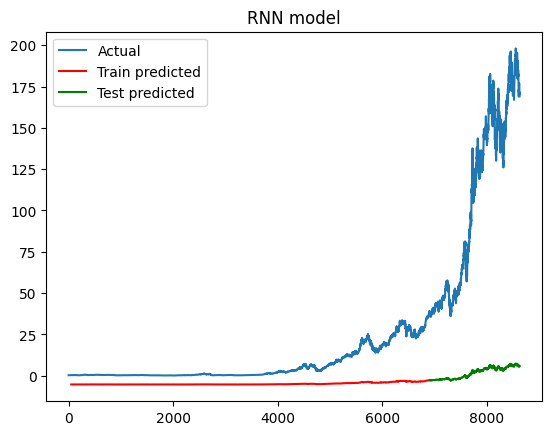

In [30]:
plot_model_results(
    title='RNN model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_rnn.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_rnn.reshape(-1, 1)).flatten(),
    lookback=lookback
)

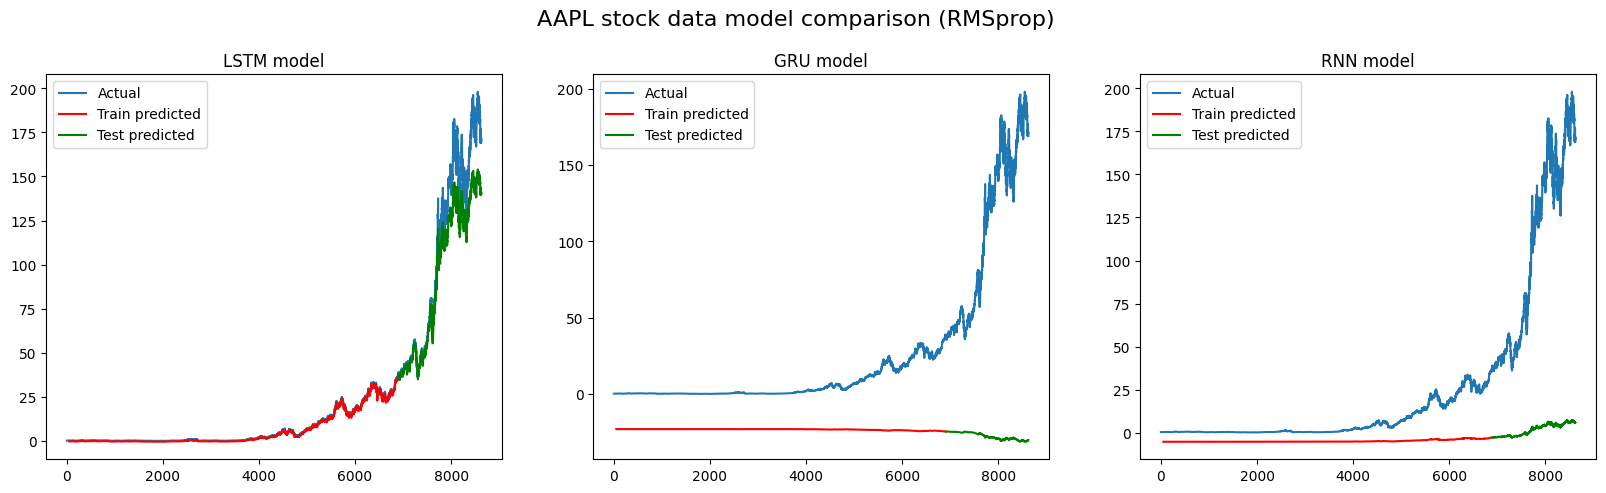

In [32]:
plot_all_results(
    title='AAPL stock data model comparison (RMSprop)',
    lookback=lookback, 
    actual=df['Open'].values,
    train_preds_lstm=scaler.inverse_transform(train_preds_lstm.reshape(-1, 1)).flatten(), 
    test_preds_lstm=scaler.inverse_transform(test_preds_lstm.reshape(-1, 1)).flatten(),
    train_preds_gru=scaler.inverse_transform(train_preds_gru.reshape(-1, 1)).flatten(), 
    test_preds_gru=scaler.inverse_transform(test_preds_gru.reshape(-1, 1)).flatten(),
    train_preds_rnn=scaler.inverse_transform(train_preds_rnn.reshape(-1, 1)).flatten(), 
    test_preds_rnn=scaler.inverse_transform(test_preds_rnn.reshape(-1, 1)).flatten()
)

W tym przypadku został użyty `RMSprop` optymalizator, i... tylko LSTM potrafił się w ogóle nauczyć. Naprowadza to na myśl, że nie dla kazdej struktury wewnętrznej modelu rekurencyjnego ten optymalizator jest odpowiedni. Widać, że RNN "probował" się nauczyc, czego nie można powiedzieć o GRU.

##### AAPL Dropout + 3 Layer

In [46]:
dropout = 0.2

In [47]:
df = yf.download('AAPL', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [48]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Open'].values.reshape(-1, 1))

In [49]:
ds = FunctionDataset(scaled_data, lookback=lookback, split_ratio=0.8)

train_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=True, batch_size=batch_size)
train_not_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=False, batch_size=batch_size)
test_loader = data.DataLoader(ds.get_test_ds(), shuffle=False, batch_size=batch_size)

[Dataset]: total samples 8628, sequence length 50, total sequences 8578, split ratio 0.8, train 6862, test 1716


In [50]:
net_lstm = LSTM(input_size=1, hidden_size=50, num_layers=3, output_size=1, dropout=dropout).cuda()
optimizer = torch.optim.Adam(net_lstm.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_lstm, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 350 batches


[  50,    6] train RMSE: 0.00916077, test RMSE: 0.125502
[ 100,    6] train RMSE: 0.00454798, test RMSE: 0.126148
[ 150,    6] train RMSE: 0.00215091, test RMSE: 0.205552
[ 200,    6] train RMSE: 0.00187154, test RMSE: 0.321555
[ 250,    6] train RMSE: 0.0020062, test RMSE: 0.346065
[ 300,    6] train RMSE: 0.00190799, test RMSE: 0.176543
[ 350,    6] train RMSE: 0.00165369, test RMSE: 0.088095
[ 400,    6] train RMSE: 0.00157898, test RMSE: 0.0814305
[ 450,    6] train RMSE: 0.00156876, test RMSE: 0.0988774
[ 500,    6] train RMSE: 0.00160219, test RMSE: 0.116956
[ 550,    6] train RMSE: 0.00150982, test RMSE: 0.150721
[ 600,    6] train RMSE: 0.00148752, test RMSE: 0.171928
[ 650,    6] train RMSE: 0.00148847, test RMSE: 0.202326
[ 700,    6] train RMSE: 0.00208879, test RMSE: 0.223507
[ 750,    6] train RMSE: 0.00190088, test RMSE: 0.23831
[ 800,    6] train RMSE: 0.0016381, test RMSE: 0.249688
[ 850,    6] train RMSE: 0.00152167, test RMSE: 0.274018
[ 900,    6] train RMSE: 0.00144

In [51]:
train_predict_loss_lstm, train_preds_lstm = predict(net_lstm, train_not_shuffle_loader, criterion)
test_predict_loss_lstm, test_preds_lstm = predict(net_lstm, test_loader, criterion)

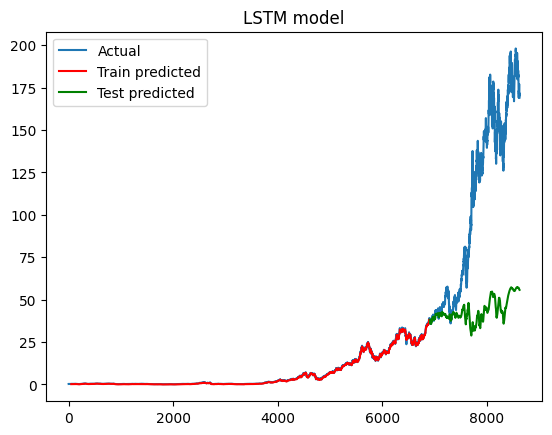

In [52]:
plot_model_results(
    title='LSTM model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_lstm.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_lstm.reshape(-1, 1)).flatten(),
    lookback=lookback
)

In [57]:
net_gru = GRU(input_size=1, hidden_size=50, num_layers=3, output_size=1, dropout=dropout).cuda()
optimizer = torch.optim.Adam(net_gru.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_gru, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 350 batches
[  50,    6] train RMSE: 0.00933346, test RMSE: 0.145542
[ 100,    6] train RMSE: 0.00561362, test RMSE: 0.113927
[ 150,    6] train RMSE: 0.0033231, test RMSE: 0.123792
[ 200,    6] train RMSE: 0.00226131, test RMSE: 0.151961
[ 250,    6] train RMSE: 0.00197527, test RMSE: 0.156302
[ 300,    6] train RMSE: 0.00210291, test RMSE: 0.158226
[ 350,    6] train RMSE: 0.0022847, test RMSE: 0.158362
[ 400,    6] train RMSE: 0.0018901, test RMSE: 0.158189
[ 450,    6] train RMSE: 0.00206936, test RMSE: 0.161696
[ 500,    6] train RMSE: 0.00189776, test RMSE: 0.166305
[ 550,    6] train RMSE: 0.0019685, test RMSE: 0.169978
[ 600,    6] train RMSE: 0.00228034, test RMSE: 0.175894
[ 650,    6] train RMSE: 0.00185971, test RMSE: 0.178566
[ 700,    6] train RMSE: 0.00197729, test RMSE: 0.185624
[ 750,    6] train RMSE: 0.00193419, test RMSE: 0.193973
[ 800,    6] train RMSE: 0.00200392, test RMSE: 0.20539
[ 850,    6] train RMSE: 0.00207052, test RMSE: 0.223397
[ 900,    6]

In [58]:
train_predict_loss_gru, train_preds_gru = predict(net_gru, train_not_shuffle_loader, criterion)
test_predict_loss_gru, test_preds_gru = predict(net_gru, test_loader, criterion)

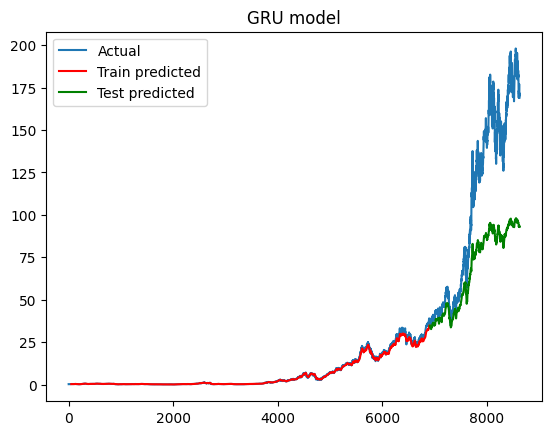

In [59]:
plot_model_results(
    title='GRU model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_gru.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_gru.reshape(-1, 1)).flatten(),
    lookback=lookback
)

In [60]:
net_rnn = RNN(input_size=1, hidden_size=50, num_layers=3, output_size=1, dropout=dropout).cuda()
optimizer = torch.optim.Adam(net_rnn.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_rnn, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 350 batches
[  50,    6] train RMSE: 0.00745034, test RMSE: 0.200994
[ 100,    6] train RMSE: 0.00524912, test RMSE: 0.186931
[ 150,    6] train RMSE: 0.00379281, test RMSE: 0.206683
[ 200,    6] train RMSE: 0.00249832, test RMSE: 0.236755
[ 250,    6] train RMSE: 0.00184816, test RMSE: 0.265139
[ 300,    6] train RMSE: 0.00180703, test RMSE: 0.273885
[ 350,    6] train RMSE: 0.00161368, test RMSE: 0.279266
[ 400,    6] train RMSE: 0.00150059, test RMSE: 0.288563
[ 450,    6] train RMSE: 0.00137516, test RMSE: 0.285718
[ 500,    6] train RMSE: 0.00162587, test RMSE: 0.285152
[ 550,    6] train RMSE: 0.00156733, test RMSE: 0.288982
[ 600,    6] train RMSE: 0.00142302, test RMSE: 0.304438
[ 650,    6] train RMSE: 0.00131277, test RMSE: 0.320759
[ 700,    6] train RMSE: 0.00119022, test RMSE: 0.31812
[ 750,    6] train RMSE: 0.0013717, test RMSE: 0.324549
[ 800,    6] train RMSE: 0.00131667, test RMSE: 0.348167
[ 850,    6] train RMSE: 0.0020306, test RMSE: 0.366309
[ 900,    

In [61]:
train_predict_loss_rnn, train_preds_rnn = predict(net_rnn, train_not_shuffle_loader, criterion)
test_predict_loss_rnn, test_preds_rnn = predict(net_rnn, test_loader, criterion)

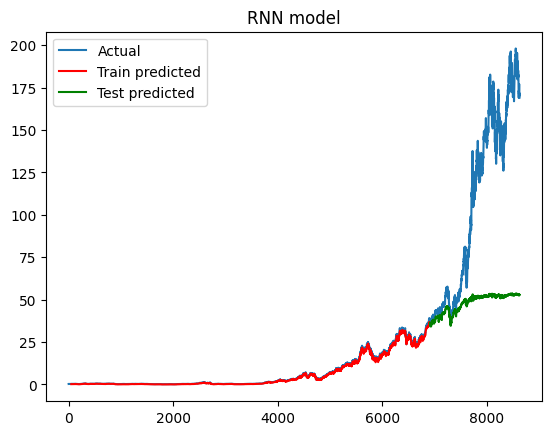

In [62]:
plot_model_results(
    title='RNN model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_rnn.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_rnn.reshape(-1, 1)).flatten(),
    lookback=lookback
)

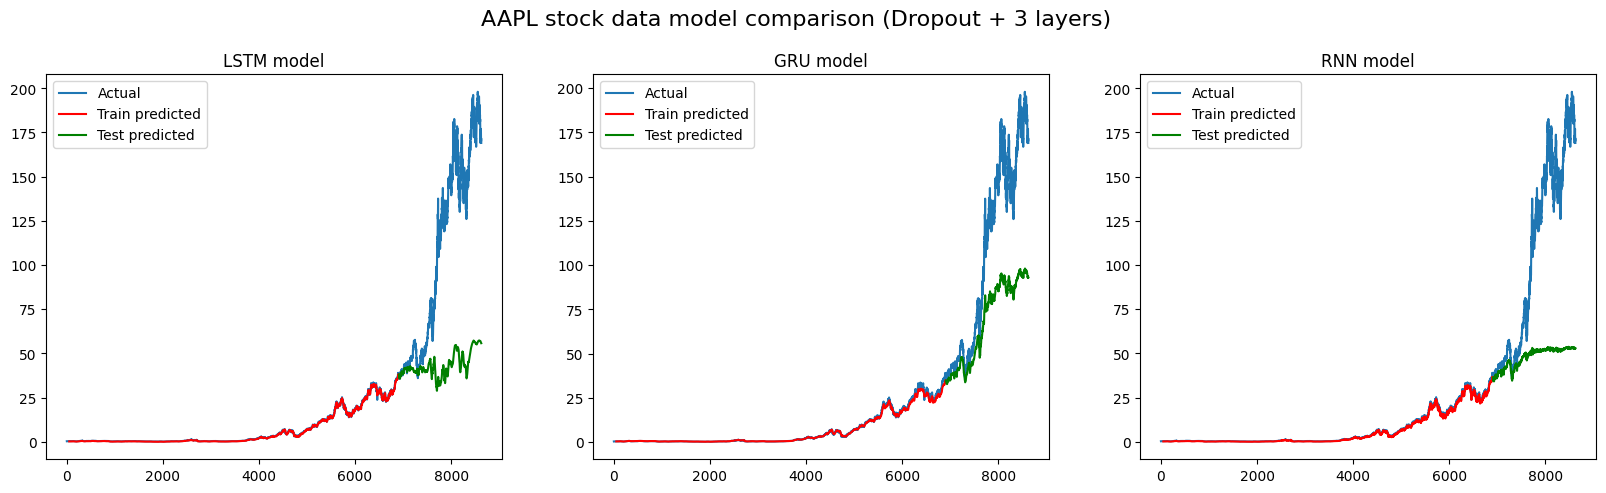

In [63]:
plot_all_results(
    title='AAPL stock data model comparison (Dropout + 3 layers)',
    lookback=lookback, 
    actual=df['Open'].values,
    train_preds_lstm=scaler.inverse_transform(train_preds_lstm.reshape(-1, 1)).flatten(), 
    test_preds_lstm=scaler.inverse_transform(test_preds_lstm.reshape(-1, 1)).flatten(),
    train_preds_gru=scaler.inverse_transform(train_preds_gru.reshape(-1, 1)).flatten(), 
    test_preds_gru=scaler.inverse_transform(test_preds_gru.reshape(-1, 1)).flatten(),
    train_preds_rnn=scaler.inverse_transform(train_preds_rnn.reshape(-1, 1)).flatten(), 
    test_preds_rnn=scaler.inverse_transform(test_preds_rnn.reshape(-1, 1)).flatten()
)

W tym przypadku pomysł był taki, że skoro mówię o przeuczeniu, to sprobuję użyć dropout. Użyć go można tylko w przypadku multilayer sieci, dlatego użyłem 3 warstw rekurencyjnych oraz dropout na poziomie 0.2 Jak Patrząć na wykresy powiedziałbym, że sieć stała się zbyt "skomplikowana" i mocno się przeuczyła: widzimy jak praktycznie identycznie powtarza learning data oraz jak źle reaguje na dane testowe. Ale i tak GRU zadziałał lepiej od pozostałych.

##### AAPL hidden size 25, layers: 2, dropout = 0.4

In [67]:
params = {
    'input_size': 1, 
    'hidden_size': 25, 
    'num_layers': 2, 
    'output_size': 1, 
    'dropout': 0.4
}

In [68]:
df = yf.download('AAPL', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [69]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Open'].values.reshape(-1, 1))

In [70]:
ds = FunctionDataset(scaled_data, lookback=lookback, split_ratio=0.8)

train_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=True, batch_size=batch_size)
train_not_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=False, batch_size=batch_size)
test_loader = data.DataLoader(ds.get_test_ds(), shuffle=False, batch_size=batch_size)

[Dataset]: total samples 8628, sequence length 50, total sequences 8578, split ratio 0.8, train 6862, test 1716


In [71]:
net_lstm = LSTM(**params).cuda()
optimizer = torch.optim.Adam(net_lstm.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_lstm, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 350 batches
[  50,    6] train RMSE: 0.0102466, test RMSE: 0.217724
[ 100,    6] train RMSE: 0.00738395, test RMSE: 0.191699
[ 150,    6] train RMSE: 0.00583271, test RMSE: 0.196051
[ 200,    6] train RMSE: 0.00455892, test RMSE: 0.196585
[ 250,    6] train RMSE: 0.00335791, test RMSE: 0.198387
[ 300,    6] train RMSE: 0.0023572, test RMSE: 0.201563
[ 350,    6] train RMSE: 0.00209678, test RMSE: 0.202408
[ 400,    6] train RMSE: 0.00228047, test RMSE: 0.203248
[ 450,    6] train RMSE: 0.0026916, test RMSE: 0.202604
[ 500,    6] train RMSE: 0.00170579, test RMSE: 0.201235
[ 550,    6] train RMSE: 0.00259047, test RMSE: 0.20357
[ 600,    6] train RMSE: 0.0014208, test RMSE: 0.207814
[ 650,    6] train RMSE: 0.00138145, test RMSE: 0.214086
[ 700,    6] train RMSE: 0.00127074, test RMSE: 0.222318
[ 750,    6] train RMSE: 0.00202774, test RMSE: 0.233566
[ 800,    6] train RMSE: 0.00144758, test RMSE: 0.245994
[ 850,    6] train RMSE: 0.001251, test RMSE: 0.259603
[ 900,    6] t

In [72]:
train_predict_loss_lstm, train_preds_lstm = predict(net_lstm, train_not_shuffle_loader, criterion)
test_predict_loss_lstm, test_preds_lstm = predict(net_lstm, test_loader, criterion)

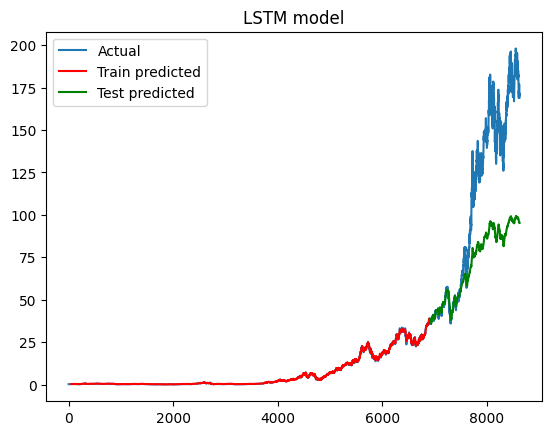

In [73]:
plot_model_results(
    title='LSTM model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_lstm.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_lstm.reshape(-1, 1)).flatten(),
    lookback=lookback
)

In [74]:
net_gru = GRU(**params).cuda()
optimizer = torch.optim.Adam(net_gru.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_gru, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 350 batches
[  50,    6] train RMSE: 0.0084947, test RMSE: 0.124909
[ 100,    6] train RMSE: 0.00572322, test RMSE: 0.0927718
[ 150,    6] train RMSE: 0.00403245, test RMSE: 0.0763424
[ 200,    6] train RMSE: 0.00306857, test RMSE: 0.0660652
[ 250,    6] train RMSE: 0.00293466, test RMSE: 0.060111
[ 300,    6] train RMSE: 0.002466, test RMSE: 0.0623066
[ 350,    6] train RMSE: 0.00215915, test RMSE: 0.0671165
[ 400,    6] train RMSE: 0.0025115, test RMSE: 0.0719819
[ 450,    6] train RMSE: 0.00222767, test RMSE: 0.0813866
[ 500,    6] train RMSE: 0.00262869, test RMSE: 0.0891851
[ 550,    6] train RMSE: 0.00300452, test RMSE: 0.0977287
[ 600,    6] train RMSE: 0.00306912, test RMSE: 0.11154
[ 650,    6] train RMSE: 0.00416372, test RMSE: 0.135387
[ 700,    6] train RMSE: 0.00586597, test RMSE: 0.166552
[ 750,    6] train RMSE: 0.00887608, test RMSE: 0.201891
[ 800,    6] train RMSE: 0.012448, test RMSE: 0.230733
[ 850,    6] train RMSE: 0.0141158, test RMSE: 0.245784
[ 900,

In [75]:
train_predict_loss_gru, train_preds_gru = predict(net_gru, train_not_shuffle_loader, criterion)
test_predict_loss_gru, test_preds_gru = predict(net_gru, test_loader, criterion)

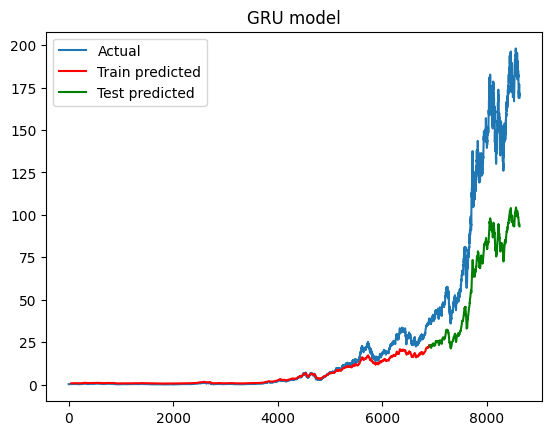

In [76]:
plot_model_results(
    title='GRU model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_gru.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_gru.reshape(-1, 1)).flatten(),
    lookback=lookback
)

In [77]:
net_rnn = RNN(**params).cuda()
optimizer = torch.optim.Adam(net_rnn.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_rnn, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 350 batches
[  50,    6] train RMSE: 0.00862917, test RMSE: 0.275854
[ 100,    6] train RMSE: 0.00701704, test RMSE: 0.25363
[ 150,    6] train RMSE: 0.00592623, test RMSE: 0.238926
[ 200,    6] train RMSE: 0.00549814, test RMSE: 0.233296
[ 250,    6] train RMSE: 0.00470441, test RMSE: 0.233711
[ 300,    6] train RMSE: 0.00396671, test RMSE: 0.232543
[ 350,    6] train RMSE: 0.00334116, test RMSE: 0.233176
[ 400,    6] train RMSE: 0.00369487, test RMSE: 0.232667
[ 450,    6] train RMSE: 0.00245183, test RMSE: 0.223077
[ 500,    6] train RMSE: 0.0023454, test RMSE: 0.217221
[ 550,    6] train RMSE: 0.00213092, test RMSE: 0.215101
[ 600,    6] train RMSE: 0.00276308, test RMSE: 0.205902
[ 650,    6] train RMSE: 0.00237015, test RMSE: 0.198469
[ 700,    6] train RMSE: 0.00258381, test RMSE: 0.191632
[ 750,    6] train RMSE: 0.00210116, test RMSE: 0.188591
[ 800,    6] train RMSE: 0.00276015, test RMSE: 0.181234
[ 850,    6] train RMSE: 0.00231987, test RMSE: 0.180029
[ 900,   

In [78]:
train_predict_loss_rnn, train_preds_rnn = predict(net_rnn, train_not_shuffle_loader, criterion)
test_predict_loss_rnn, test_preds_rnn = predict(net_rnn, test_loader, criterion)

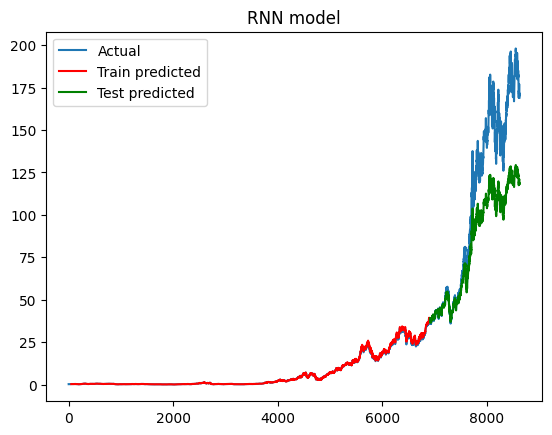

In [79]:
plot_model_results(
    title='RNN model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_rnn.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_rnn.reshape(-1, 1)).flatten(),
    lookback=lookback
)

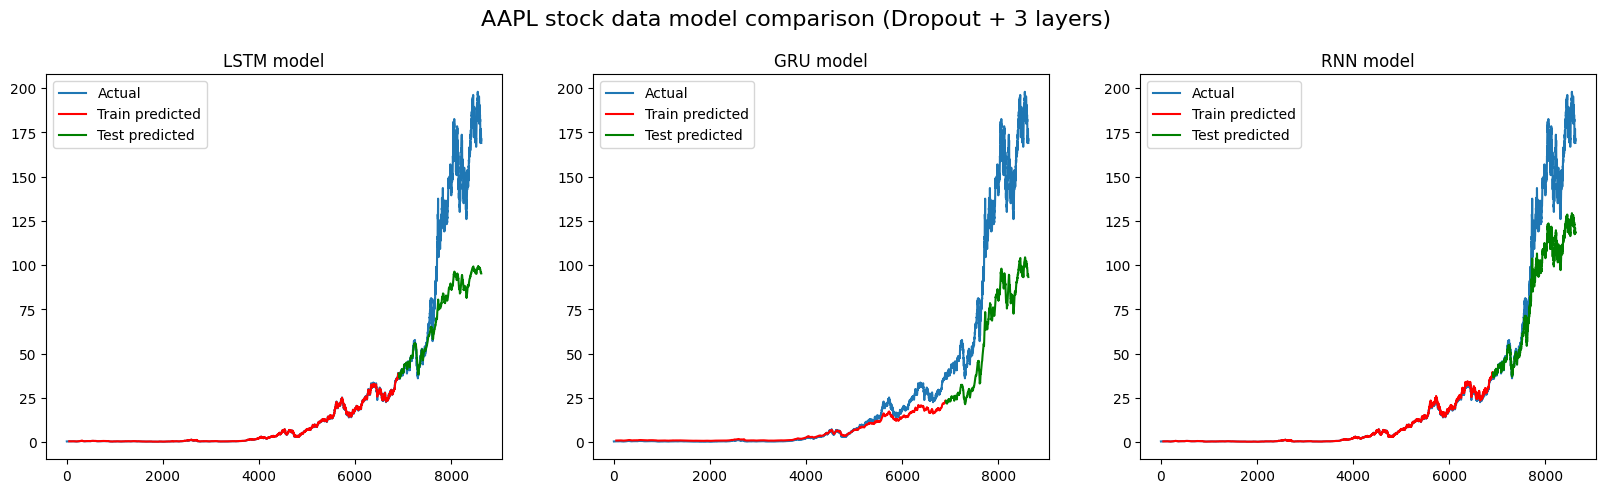

In [80]:
plot_all_results(
    title='AAPL stock data model comparison (Dropout + 3 layers)',
    lookback=lookback, 
    actual=df['Open'].values,
    train_preds_lstm=scaler.inverse_transform(train_preds_lstm.reshape(-1, 1)).flatten(), 
    test_preds_lstm=scaler.inverse_transform(test_preds_lstm.reshape(-1, 1)).flatten(),
    train_preds_gru=scaler.inverse_transform(train_preds_gru.reshape(-1, 1)).flatten(), 
    test_preds_gru=scaler.inverse_transform(test_preds_gru.reshape(-1, 1)).flatten(),
    train_preds_rnn=scaler.inverse_transform(train_preds_rnn.reshape(-1, 1)).flatten(), 
    test_preds_rnn=scaler.inverse_transform(test_preds_rnn.reshape(-1, 1)).flatten()
)

W tym przypadku "uprościłem sieć" poprzez zmniejszenie `hidden_size`, zmniejszenie ilości warstw do 2 oraz użycie dropout na poziomie 0.4. Widzimy, że wyniki są znacznie lepsze od poprzednich. Najlpszy wynik osiągnął RNN.

#### AAPL use bidirectional

In [106]:
params = {
    'input_size': 1, 
    'hidden_size': 20, 
    'num_layers': 2, 
    'output_size': 1, 
    'dropout': 0.5,
    'bidirectional': True
}

In [107]:
df = yf.download('AAPL', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [108]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Open'].values.reshape(-1, 1))

In [109]:
ds = FunctionDataset(scaled_data, lookback=lookback, split_ratio=0.8)

train_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=True, batch_size=batch_size)
train_not_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=False, batch_size=batch_size)
test_loader = data.DataLoader(ds.get_test_ds(), shuffle=False, batch_size=batch_size)

[Dataset]: total samples 8628, sequence length 50, total sequences 8578, split ratio 0.8, train 6862, test 1716


In [110]:
net_lstm = LSTM(**params).cuda()
optimizer = torch.optim.Adam(net_lstm.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_lstm, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 350 batches
[  50,    6] train RMSE: 0.0092193, test RMSE: 0.345709
[ 100,    6] train RMSE: 0.00524493, test RMSE: 0.45932
[ 150,    6] train RMSE: 0.00398128, test RMSE: 0.443381
[ 200,    6] train RMSE: 0.0033385, test RMSE: 0.444318
[ 250,    6] train RMSE: 0.00332796, test RMSE: 0.446477
[ 300,    6] train RMSE: 0.00345357, test RMSE: 0.439009
[ 350,    6] train RMSE: 0.00331028, test RMSE: 0.430704
[ 400,    6] train RMSE: 0.00359052, test RMSE: 0.425734
[ 450,    6] train RMSE: 0.00363042, test RMSE: 0.422888
[ 500,    6] train RMSE: 0.00331738, test RMSE: 0.422476
[ 550,    6] train RMSE: 0.00356339, test RMSE: 0.421134
[ 600,    6] train RMSE: 0.00324362, test RMSE: 0.418965
[ 650,    6] train RMSE: 0.00352623, test RMSE: 0.421116
[ 700,    6] train RMSE: 0.00292897, test RMSE: 0.421198
[ 750,    6] train RMSE: 0.0030991, test RMSE: 0.421867
[ 800,    6] train RMSE: 0.00341034, test RMSE: 0.423929
[ 850,    6] train RMSE: 0.00327745, test RMSE: 0.426978
[ 900,    6

In [111]:
train_predict_loss_lstm, train_preds_lstm = predict(net_lstm, train_not_shuffle_loader, criterion)
test_predict_loss_lstm, test_preds_lstm = predict(net_lstm, test_loader, criterion)

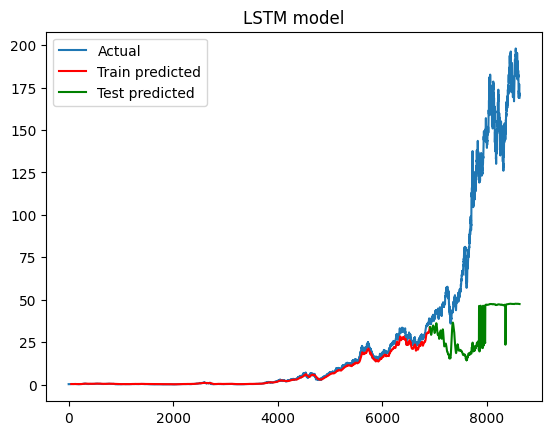

In [112]:
plot_model_results(
    title='LSTM model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_lstm.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_lstm.reshape(-1, 1)).flatten(),
    lookback=lookback
)

In [113]:
net_gru = GRU(**params).cuda()
optimizer = torch.optim.Adam(net_gru.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_gru, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 350 batches
[  50,    6] train RMSE: 0.00576491, test RMSE: 0.117138
[ 100,    6] train RMSE: 0.00441086, test RMSE: 0.111671
[ 150,    6] train RMSE: 0.00353218, test RMSE: 0.124349
[ 200,    6] train RMSE: 0.00273321, test RMSE: 0.141413
[ 250,    6] train RMSE: 0.00230775, test RMSE: 0.159324
[ 300,    6] train RMSE: 0.00215346, test RMSE: 0.168991
[ 350,    6] train RMSE: 0.00297784, test RMSE: 0.171351
[ 400,    6] train RMSE: 0.00280715, test RMSE: 0.175179
[ 450,    6] train RMSE: 0.00252355, test RMSE: 0.175733
[ 500,    6] train RMSE: 0.00295143, test RMSE: 0.180344
[ 550,    6] train RMSE: 0.00224031, test RMSE: 0.182895
[ 600,    6] train RMSE: 0.00369615, test RMSE: 0.197117
[ 650,    6] train RMSE: 0.00392034, test RMSE: 0.20942
[ 700,    6] train RMSE: 0.00474193, test RMSE: 0.226571
[ 750,    6] train RMSE: 0.00539801, test RMSE: 0.244234
[ 800,    6] train RMSE: 0.00629365, test RMSE: 0.264662
[ 850,    6] train RMSE: 0.00692981, test RMSE: 0.286098
[ 900,  

In [114]:
train_predict_loss_gru, train_preds_gru = predict(net_gru, train_not_shuffle_loader, criterion)
test_predict_loss_gru, test_preds_gru = predict(net_gru, test_loader, criterion)

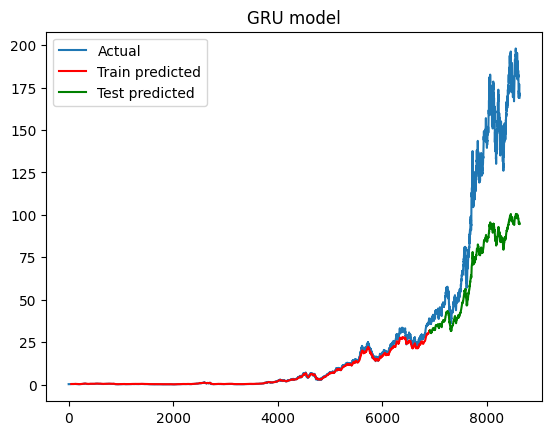

In [115]:
plot_model_results(
    title='GRU model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_gru.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_gru.reshape(-1, 1)).flatten(),
    lookback=lookback
)

In [116]:
net_rnn = RNN(**params).cuda()
optimizer = torch.optim.Adam(net_rnn.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_rnn, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 350 batches
[  50,    6] train RMSE: 0.00720949, test RMSE: 0.248714
[ 100,    6] train RMSE: 0.006026, test RMSE: 0.226019
[ 150,    6] train RMSE: 0.00528865, test RMSE: 0.190303
[ 200,    6] train RMSE: 0.00452617, test RMSE: 0.166251
[ 250,    6] train RMSE: 0.00419443, test RMSE: 0.149295
[ 300,    6] train RMSE: 0.00367332, test RMSE: 0.13689
[ 350,    6] train RMSE: 0.00329519, test RMSE: 0.126599
[ 400,    6] train RMSE: 0.00297773, test RMSE: 0.120265
[ 450,    6] train RMSE: 0.00302248, test RMSE: 0.11877
[ 500,    6] train RMSE: 0.00231999, test RMSE: 0.12115
[ 550,    6] train RMSE: 0.00203396, test RMSE: 0.127771
[ 600,    6] train RMSE: 0.00277076, test RMSE: 0.132471
[ 650,    6] train RMSE: 0.00187788, test RMSE: 0.139927
[ 700,    6] train RMSE: 0.00160242, test RMSE: 0.148063
[ 750,    6] train RMSE: 0.0015784, test RMSE: 0.153631
[ 800,    6] train RMSE: 0.00159639, test RMSE: 0.157063
[ 850,    6] train RMSE: 0.00155045, test RMSE: 0.163689
[ 900,    6] 

In [117]:
train_predict_loss_rnn, train_preds_rnn = predict(net_rnn, train_not_shuffle_loader, criterion)
test_predict_loss_rnn, test_preds_rnn = predict(net_rnn, test_loader, criterion)

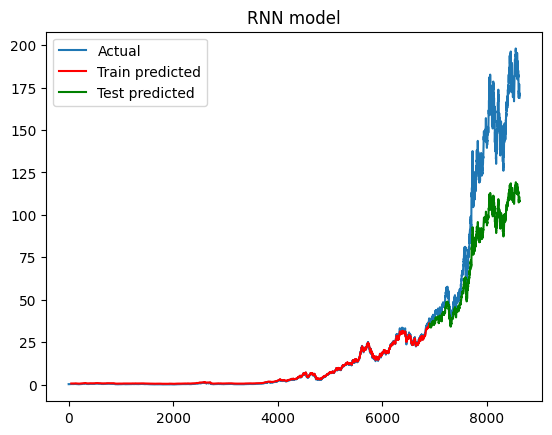

In [118]:
plot_model_results(
    title='RNN model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_rnn.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_rnn.reshape(-1, 1)).flatten(),
    lookback=lookback
)

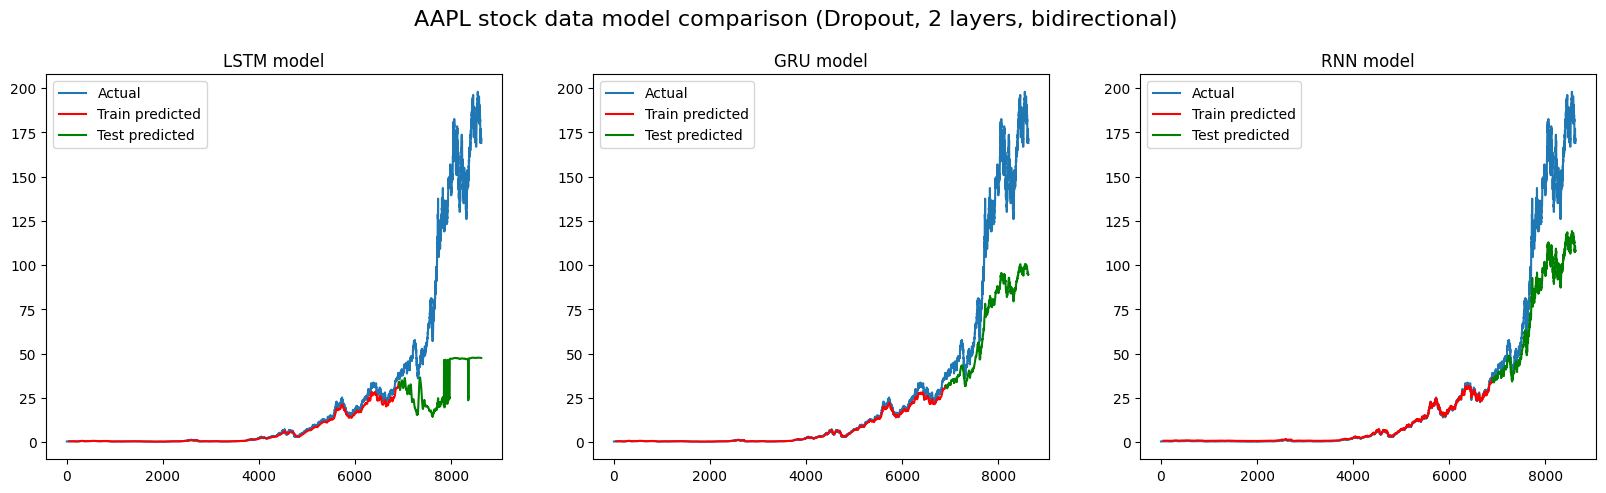

In [119]:
plot_all_results(
    title='AAPL stock data model comparison (Dropout, 2 layers, bidirectional)',
    lookback=lookback, 
    actual=df['Open'].values,
    train_preds_lstm=scaler.inverse_transform(train_preds_lstm.reshape(-1, 1)).flatten(), 
    test_preds_lstm=scaler.inverse_transform(test_preds_lstm.reshape(-1, 1)).flatten(),
    train_preds_gru=scaler.inverse_transform(train_preds_gru.reshape(-1, 1)).flatten(), 
    test_preds_gru=scaler.inverse_transform(test_preds_gru.reshape(-1, 1)).flatten(),
    train_preds_rnn=scaler.inverse_transform(train_preds_rnn.reshape(-1, 1)).flatten(), 
    test_preds_rnn=scaler.inverse_transform(test_preds_rnn.reshape(-1, 1)).flatten()
)

W tym przypadku chciałem sprawdzić jak zadziała "zaglądanie do przyszłości" i włączyłem `bidirectional` (wymagało to małej zmiany modelu). Też zwiększyłem dropout do 0.5. I w tym przypadku najlepiej zadziałał RNN, natomiast duża różnica jest przy LSTM (wyniki są gorze). Też powiedziałbym, że GRU osiągnął troche lepsze wyniki w porównaniu do poprzedniego eksperymentu.